<a href="https://colab.research.google.com/github/alezakuskin/Stark_ML/blob/Temperature-tuning/Main_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarkML: Machine Learning-based Tool for Predicting Stark Parameters of Atomic Emission Lines

# Imports

In [1]:
!pip install pytorch-tabnet
!git clone -b Temperature-tuning https://github.com/alezakuskin/Stark_ML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 5.8 MB/s eta 0:00:00
Cloning into 'Stark_ML'...
remote: Enumerating objects: 1209, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 1209 (delta 63), reused 64 (delta 45), pack-reused 1116
Receiving objects: 100% (1209/1209), 40.18 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (693/693), done.


In [2]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
import lightgbm
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

import pytorch_tabnet
os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
if os.name == 'nt':
    !cd /d %tabnet% & patch < "%patchfile%"
else:
    !cd $tabnet && patch -f < $patchfile
importlib.reload(pytorch_tabnet)

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [3]:
#Download and import all utilities and models
if os.path.isdir('Stark_ML'):
    import Stark_ML
    def remove_readonly(func, path, _):
            os.chmod(path, stat.S_IWRITE)
            func(path)
    shutil.rmtree(Stark_ML.__path__.__dict__['_path'][0], onerror = remove_readonly)

!git clone -b Temperature-tuning https://github.com/alezakuskin/Stark_ML

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
from pytorch_tabnet.tab_model import  TabNetRegressor
clear_output()

# Data preprocessing

In [4]:
#Import data for training and testing
data = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
#Replace term symbols with quantum numbers
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

/content/Stark_ML/utils/terms.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()
/content/Stark_ML/utils/terms.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()


In [5]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [6]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

#Separate targets from data
target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

#Separate labels from data
label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

In [7]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

#print(target_test_q4[target_test_q4 > 70])

#Combining quartiles into full test dataset
data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

#Remove test entries from data -> get train set
data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

<ipython-input-7-40f094bfc1ca>:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_test_q4 = pd.Series()


In [8]:
#Step 4. Augmentation. Applied only to train set
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
data_width_train_extended = data_width_train.copy()
target_width_train_extended = target_width_train
for index, row in data_width_train.iterrows():
    row['T'] = row['T']*factor
    data_width_train_extended = pd.concat([data_width_train_extended, row.to_frame().T], ignore_index=True)
    target_width_train_extended = pd.concat([target_width_train_extended, pd.Series(target_width_train.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_train_extended = pd.concat([data_width_train_extended, row.to_frame().T], ignore_index=True)
    target_width_train_extended = pd.concat([target_width_train_extended, pd.Series(target_width_train.loc[index])], ignore_index=True)
data_width_train_extended = data_width_train_extended.astype(data_width_train.dtypes.to_dict())

## -- *OPTIONAL*-- Width data visual description

In [ ]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [ ]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


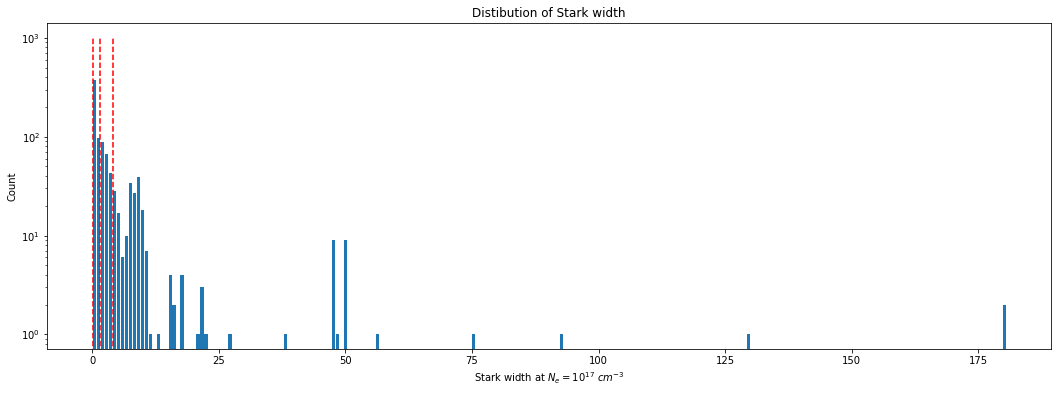

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

<ipython-input-52-3d8ce1c69243>:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
<ipython-input-52-3d8ce1c69243>:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
<ipython-input-52-3d8ce1c69243>:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
<ipython-input-52-3d8ce1c69243>:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])


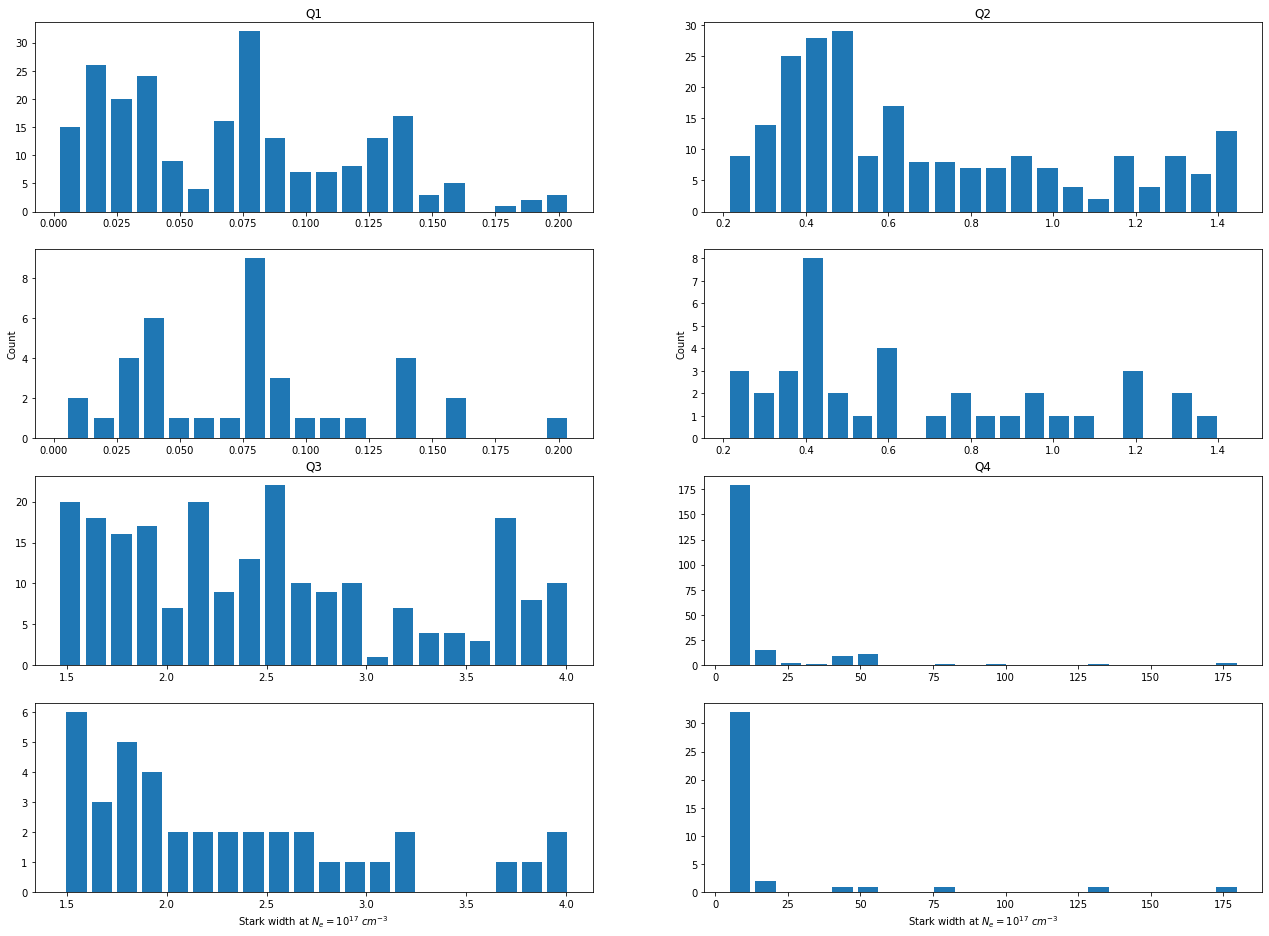

In [ ]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

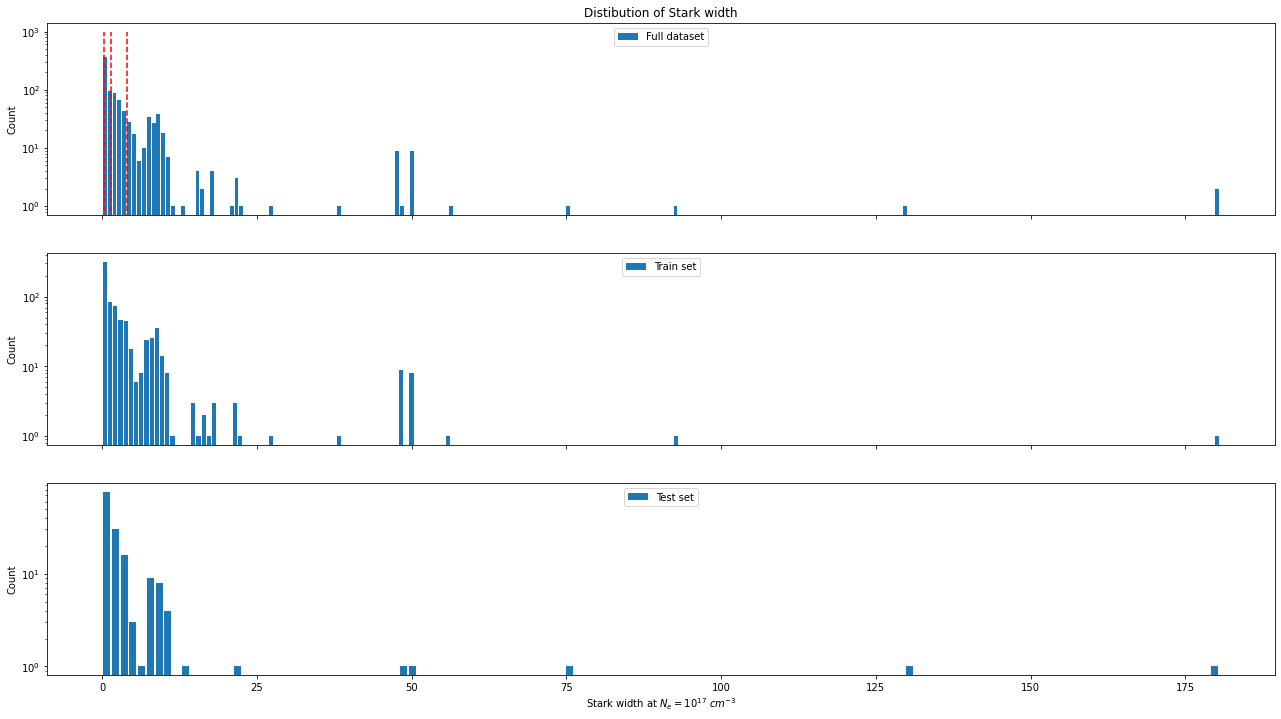

In [ ]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

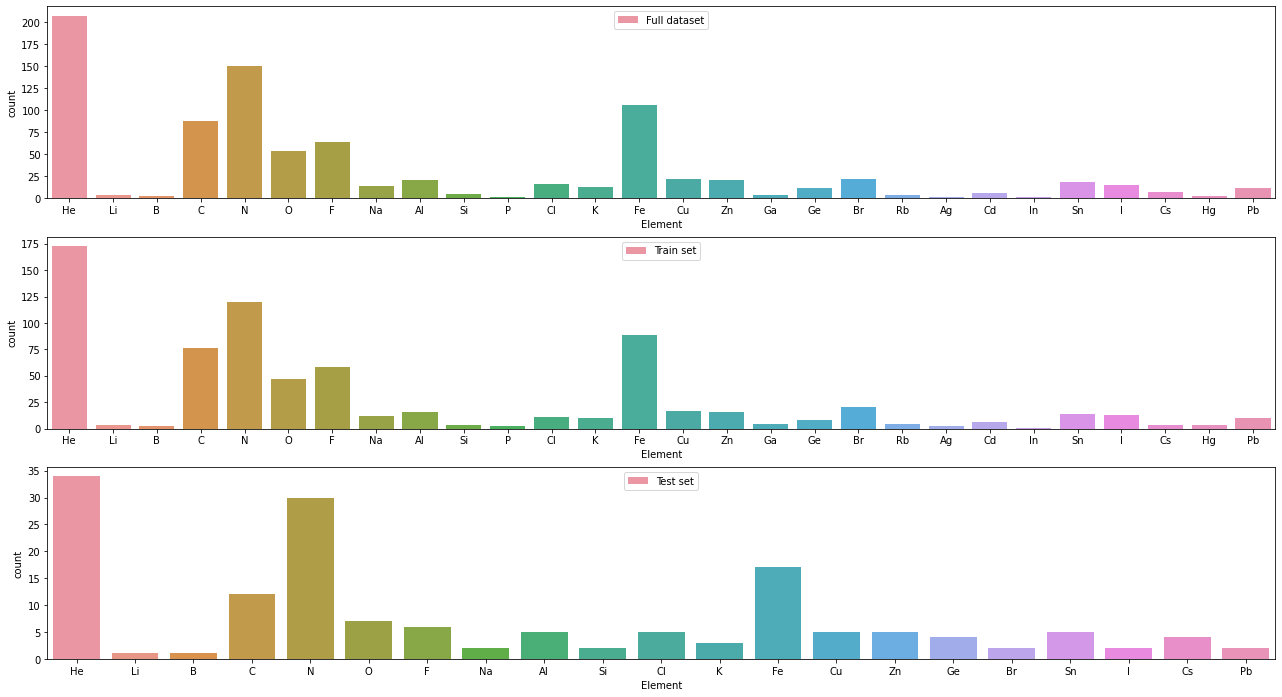

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [9]:
#Creating data, target and labels for shift prediction
data_shift = data[np.isnan(data['d (A)']) == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

In [10]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

<ipython-input-10-e1a2b1897dfc>:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_test_q4 = pd.Series()


## -- *OPTIONAL*-- Shift data visual description 

In [ ]:
data_shift.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.0,331.0,331.0,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000
mean,479.888947,14.045317,1.740181,1.531722,3.308157,0.737160,1.435045,1.797583,0.314199,0.749245,...,0.003021,0.0,0.0,0.0,2.764350,1.187311,0.555891,1.480363,4.027146e+05,17826.404834
std,192.056662,17.933067,0.439199,0.802301,2.162047,0.853039,2.371135,3.775294,0.694837,1.845705,...,0.054965,0.0,0.0,0.0,1.114123,0.864075,0.497619,0.999428,5.473695e+06,9920.444183
min,119.955000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.173231e+04,3800.000000
25%,391.633000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,2.000000,1.000000,0.000000,1.000000,5.375643e+04,11000.000000
50%,501.568000,8.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,1.000000,1.000000,1.500000,9.966391e+04,15000.000000
75%,589.200750,13.000000,2.000000,2.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,2.000000,1.000000,2.000000,1.832368e+05,22700.000000
max,852.112000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,0.0,0.0,0.0,7.000000,5.000000,1.000000,7.000000,9.968131e+07,49000.000000


count    331.000000
mean       2.034925
std        3.704571
min       -7.485437
25%        0.037200
50%        0.290000
75%        2.881356
max       20.000000
Name: d (A), dtype: float64


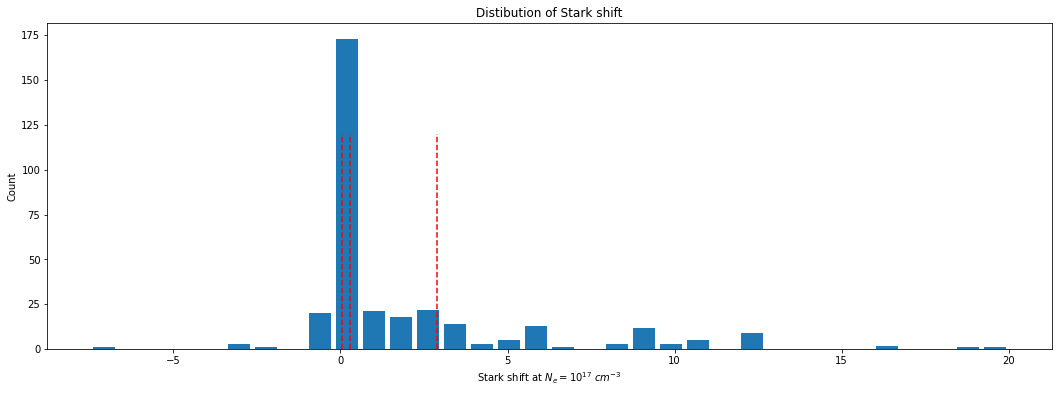

In [ ]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins='auto', log=False, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

<ipython-input-61-9c98c9a4bf53>:18: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
<ipython-input-61-9c98c9a4bf53>:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
<ipython-input-61-9c98c9a4bf53>:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
<ipython-input-61-9c98c9a4bf53>:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])


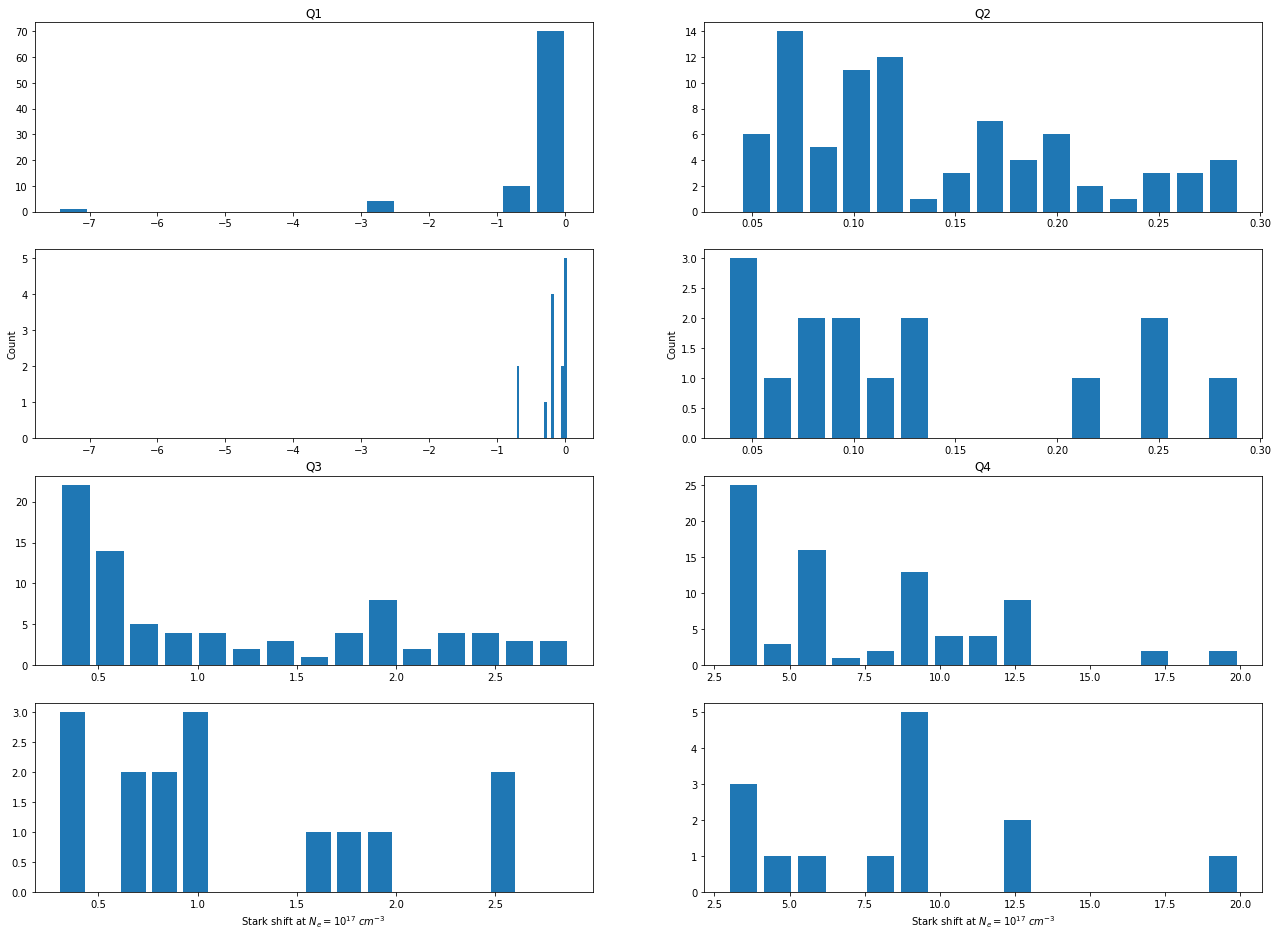

In [ ]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

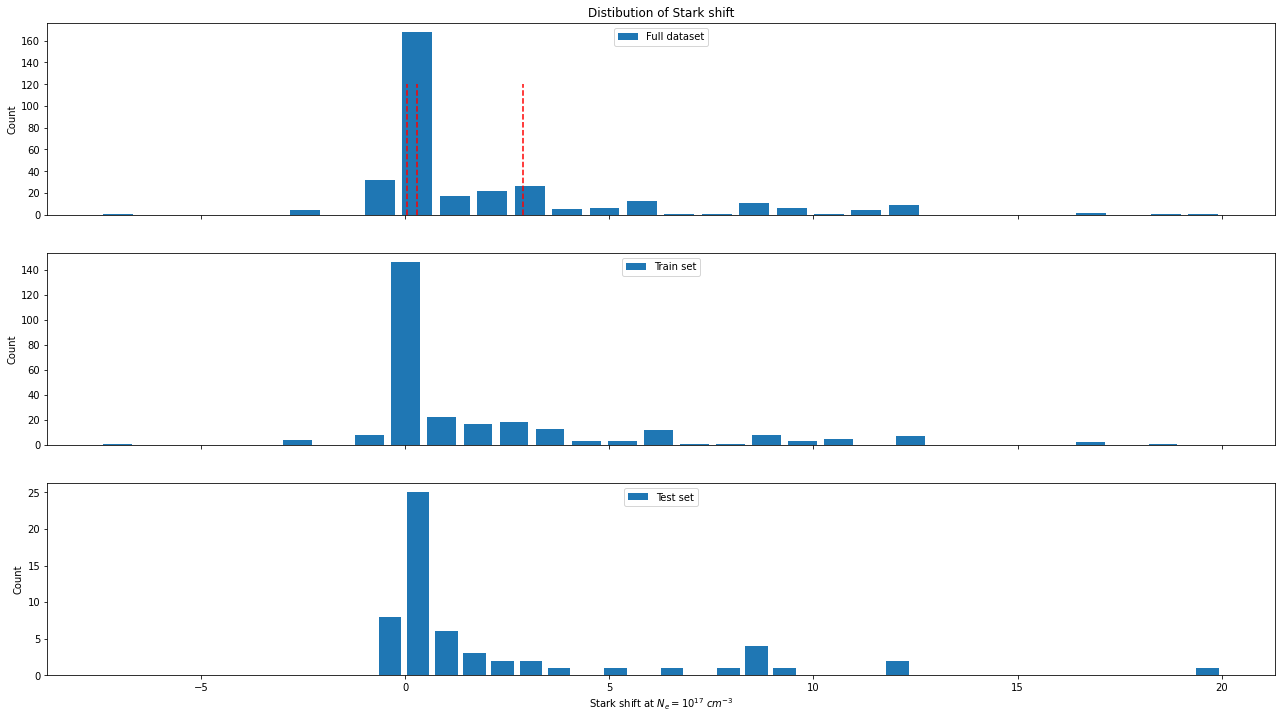

In [ ]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

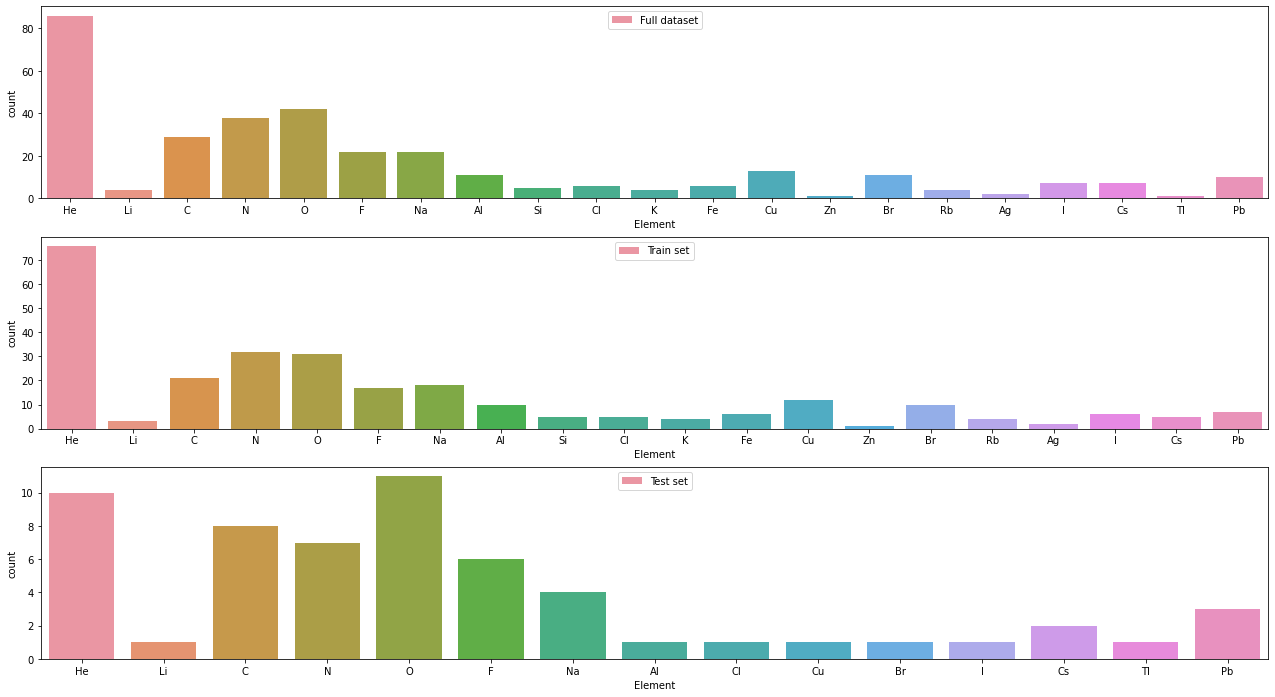

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Both data preprocessing (currently not used anywhere further)

In [11]:
#Selecting items for predicting both parameters simultaneously (currently not used anywhere further)
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

In [12]:
#@title Use augmented train set?

augmented_train_set = True#@param {type:"boolean"}
#@markdown Note: augmentation will be applied to width only 

#@markdown ---

#@markdown Select whether you'd like to work with 'width' or 'shift' predictions
parameter  = 'width' #@param ["width", "shift"]

#@markdown ---

#@markdown You can enter any reasonable value less than 180 Angstrom to limit the upper boundary of width walues. (not recommended to change)
width_threshold =  200#@param {type:"number"}

#@markdown ---

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

In [38]:
#Assigning proper variables
#Assigning width wariables
if augmented_train_set:
    XW_train, YW_train = data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train_extended
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
else:
    XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
XW_train = XW_train.sample(frac = 1, random_state = 777)                        #reshuffle
YW_train = YW_train.sample(frac = 1, random_state = 777)

#Assigning shift variables
XS_train, YS_train = data_shift_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_train
XS_test, YS_test = data_shift_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_test
XS_train = XS_train.sample(frac = 1, random_state = 777)
YS_train = YS_train.sample(frac = 1, random_state = 777)

#Assigning proper variables for elements-exclusive test set
XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

XS_elem = data_shift_elements.drop(columns=['Element', 'Wavelength', 'Z number', 'd (A)', 'w (A)'])
YS_elem = target_shift_elements
LS_elem = label_shift_elements


#Applying upper boundary to width values
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]


#Applying scaling of width targets
if scaled_target:
    YW_train = np.log(1 + YW_train / epsilon)
    YW_test = np.log(1 + YW_test / epsilon)
    YW_elem = np.log(1 + YW_elem / epsilon)


#Applying 'width' or 'shift selection
if parameter == 'width':
    X_train, Y_train = XW_train, YW_train
    X_test, Y_test = XW_test, YW_test
    X_elem, Y_elem, L_elem = XW_elem, YW_elem, LW_elem
else:
    X_train, Y_train = XS_train, YS_train
    X_test, Y_test = XS_test, YS_test
    X_elem, Y_elem, L_elem = XS_elem, YS_elem, XS_elem


print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 331
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


# Models optimization

## KNN

In [24]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = KNN

KNN_res = main(X = X_train, y = Y_train, model_name = model_name, params = KNN_params, n_trials = 10)

'''with open(f'KNN_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

with open(f'KNN_Extended_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)'''

[I 2023-03-24 10:00:24,059] A new study created in memory with name: no-name-85a7d105-c615-4b82-b961-2763a4200ae3


Start hyperparameter optimization


/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

{'n_neighbors': 39, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.8694654110006803}
{'n_neighbors': 95, 'weights': 'distance', 'leaf_size': 43, 'p': 1.873869762688754}
[I 2023-03-24 10:00:29,157] Trial 0 finished with value: 0.5929116588937922 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.8694654110006803}. Best is trial 0 with value: 0.5929116588937922.
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 8, 'p': 1.2565622395144382}
[I 2023-03-24 10:00:29,238] Trial 1 finished with value: 0.3924672503099567 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'leaf_size': 43, 'p': 1.873869762688754}. Best is trial 1 with value: 0.3924672503099567.
{'n_neighbors': 70, 'weights': 'distance', 'leaf_size': 39, 'p': 1.2581472813435135}
[I 2023-03-24 10:00:33,855] Trial 2 finished with value: 0.3186998476545705 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 8, 'p': 1.2565622395144382}. Best is trial 2 with value: 0.3186998476

"with open(f'KNN_{width_threshold}max_optimal_parameters', 'w') as fp:\n    json.dump(KNN_res.best_params, fp)\n\nwith open(f'KNN_Extended_optimal_parameters', 'w') as fp:\n    json.dump(KNN_res.best_params, fp)"

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


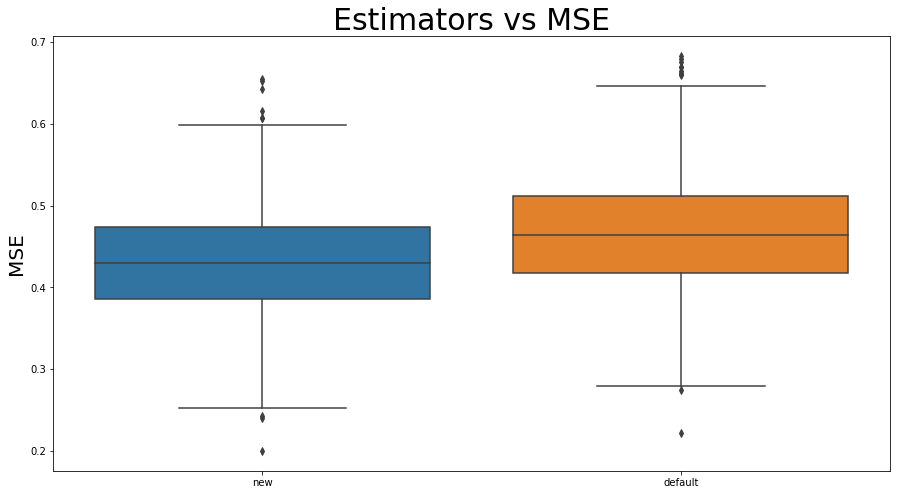

In [25]:
#Compare default KNN vs optimised KNN
KNN_params = KNN_res.best_params

models = {}

models['new'] = KNeighborsRegressor(**KNN_params)
models['default'] = KNeighborsRegressor()

results = train_and_test_regressor(models, X_train, Y_train, X_test, Y_test)

plot_model_comparison(results)

In [27]:
#Visualise importance of KNN model parameters
optuna.visualization.plot_param_importances(KNN_res)

In [28]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [29]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error', 'poisson'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = RandomForest

RF_res = main(X = X_train, y = Y_train, model_name = model_name, params = RF_params, n_trials = 250)

'''with open(f'RF_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)'''

'''with open(f'RF_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(RF_res.best_params, fp)'''

'''with open(f'RF_Extended_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)'''

[I 2023-03-24 10:04:28,282] A new study created in memory with name: no-name-d5decee4-cb57-4a15-a12d-da4ad6c9e69a


Start hyperparameter optimization


/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/10 [00:00<?, ?it/s]

{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'squared_error'}
[I 2023-03-24 10:04:32,848] Trial 0 finished with value: 0.26218972970192134 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.26218972970192134.
{'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}
[I 2023-03-24 10:04:32,935] Trial 1 finished with value: 0.28129950036923845 and parameters: {'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.26218972970192134.
{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
[I 2023-03-24 10:04:37,989] Trial 2 finished with value: 0.

"with open(f'RF_Extended_optimal_parameters', 'w') as fp:\n    json.dump(RF_res.best_params, fp)"

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


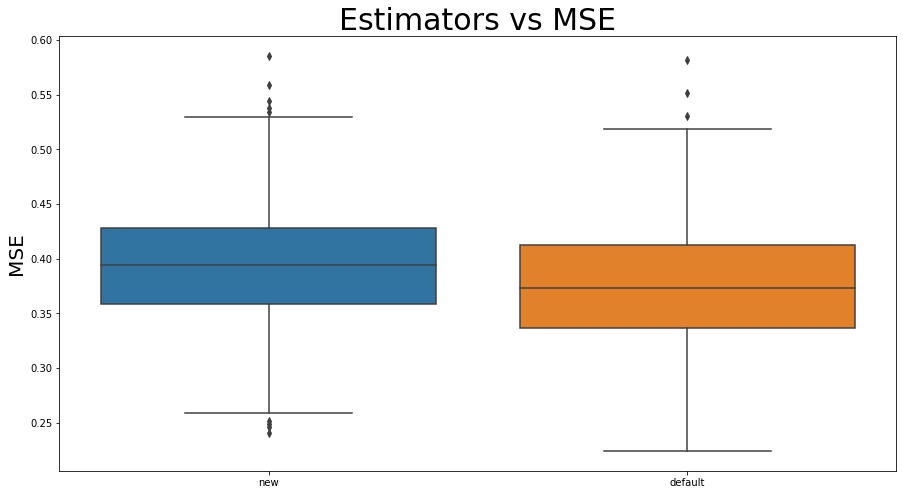

In [30]:
#Compare default RandomForest vs optimised RandomForest
RF_params = RF_res.best_params

models_RF = {}

models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)
models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_RF)

Fitting 10
Fitting 20
Fitting 30
Fitting 40
Fitting 50
Fitting 60
Fitting 70
Fitting 80
Fitting 90
Fitting 100
Fitting 110
Fitting 120
Fitting 130
Fitting 140
Fitting 150
Fitting 160
Fitting 170
Fitting 180
Fitting 190
Fitting 200
Calculating bootstrap score for 10
Calculating bootstrap score for 20
Calculating bootstrap score for 30
Calculating bootstrap score for 40
Calculating bootstrap score for 50
Calculating bootstrap score for 60
Calculating bootstrap score for 70
Calculating bootstrap score for 80
Calculating bootstrap score for 90
Calculating bootstrap score for 100
Calculating bootstrap score for 110
Calculating bootstrap score for 120
Calculating bootstrap score for 130
Calculating bootstrap score for 140
Calculating bootstrap score for 150
Calculating bootstrap score for 160
Calculating bootstrap score for 170
Calculating bootstrap score for 180
Calculating bootstrap score for 190
Calculating bootstrap score for 200


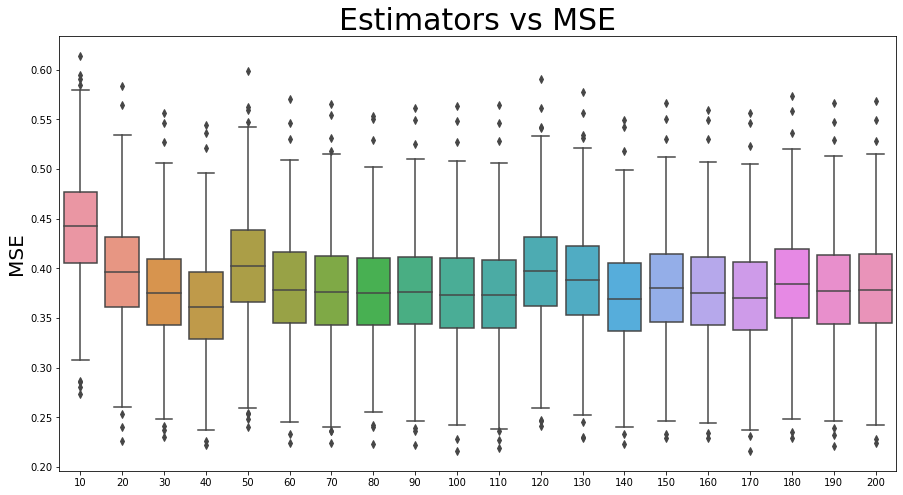

In [32]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 201, 10):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [33]:
optuna.visualization.plot_param_importances(RF_res)

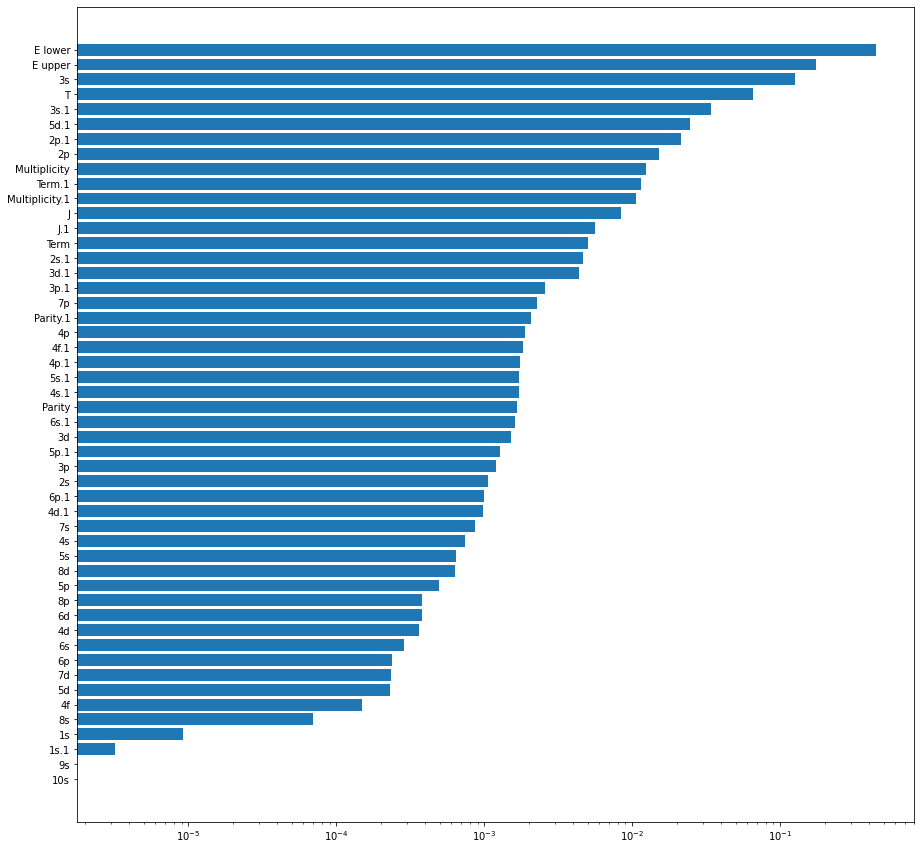

In [34]:
#Visualising feature importances for the optimal RF model
feature_importance = models_RF['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

## Gradient Boosting

In [35]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = Gradient_Boosting

GB_res = main(X = X_train, y = Y_train, model_name = model_name, params = GB_params, n_trials = 10)

'''with open(f'GB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)
'''
'''with open(f'GB_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(GB_res.best_params, fp)'''

'''with open(f'GB_Extended_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)'''

[I 2023-03-24 10:24:51,613] A new study created in memory with name: no-name-f1591d2b-e25b-48a6-98b0-e71d8a06cfd4


Start hyperparameter optimization


/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/10 [00:00<?, ?it/s]

{'n_estimators': 100, 'learning_rate': 0.08316771182535565, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.04415222131770911, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 5}
[I 2023-03-24 10:24:56,759] Trial 1 finished with value: 0.17448761082700465 and parameters: {'learning_rate': 0.04415222131770911, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.17448761082700465.
{'n_estimators': 100, 'learning_rate': 0.01671530041921643, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 1}
[I 2023-03-24 10:24:58,479] Trial 0 finished with value: 0.16994440039233807 and parameters: {'learning_rate': 0.08316771182535565, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.16994440039233807.
{'n_estimators': 100, 'learning_rate': 0.0402654489169866, 'loss': 'huber', 'max_depth': 43, 'min_samples_leaf': 7}
[I 2023-03-24 1

"with open(f'GB_Extended_optimal_parameters', 'w') as fp:\n    json.dump(GB_res.best_params, fp)"

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


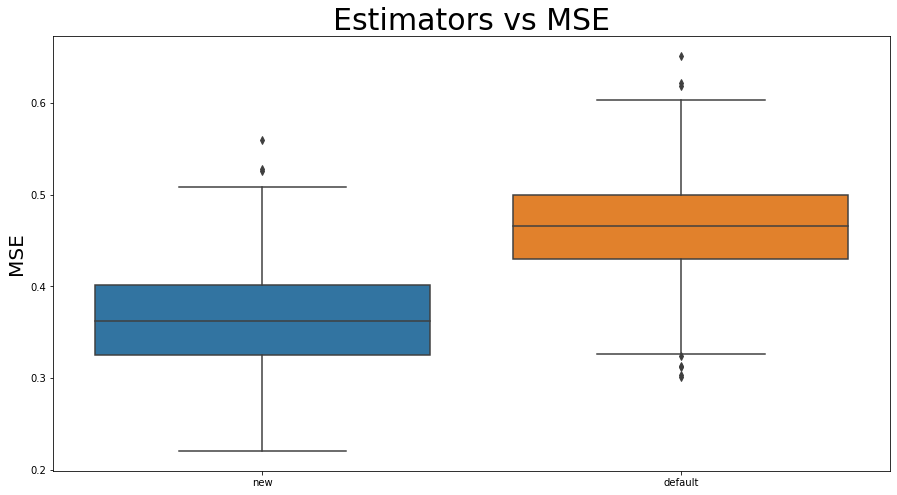

In [36]:
#Compare default GradientBoosting vs optimised GradientBoosting
GB_params = GB_res.best_params

models_GB = {}

models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)
models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_GB)

In [37]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(GB_res)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.



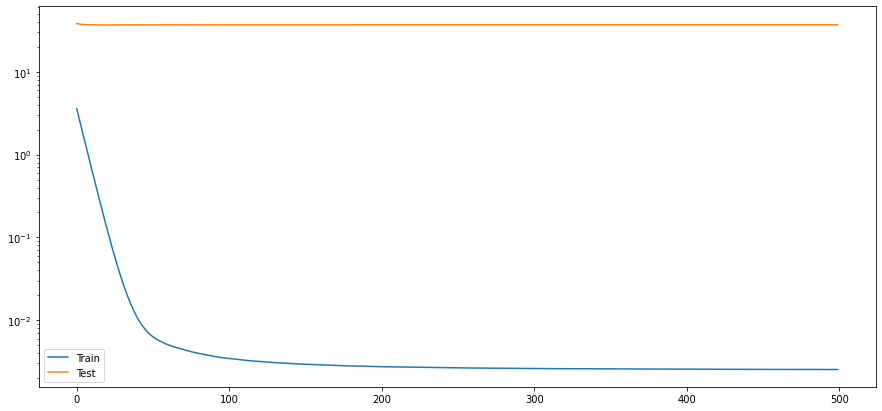

In [40]:
#Visualising selection of n_estimators and potential overfitting
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XS_test)):
    test_score[i] = models_GB['new'].loss_(YS_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

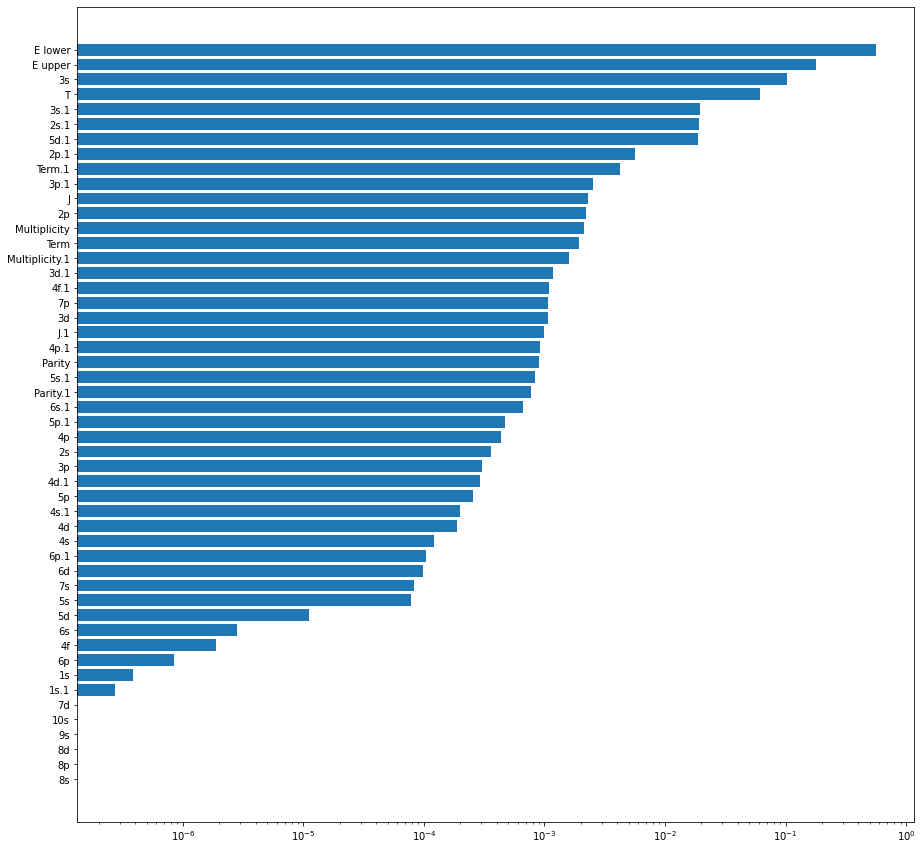

In [39]:
#Visualising feature importances for the optimal RF model
feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## XGBoost

In [98]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 20],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = XGBoost

XGB_res = main(X = X_train, y = Y_train, model_name = model_name, params = XGB_params, n_trials = 250)

'''with open(f'XGB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)
'''
'''with open(f'XGB_Extended_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)'''

[I 2023-03-24 12:01:24,135] A new study created in memory with name: no-name-dcfb901e-189e-47b2-bc03-7a437073d80f


Start hyperparameter optimization


/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/10 [00:00<?, ?it/s]

{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.48496618548026715, 'min_child_weight': 7, 'reg_alpha': 3.9008028542168533e-07, 'reg_lambda': 0.012178782021964376}{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.37575416685045876, 'min_child_weight': 12, 'reg_alpha': 5.714178155164601, 'reg_lambda': 1.687930353629757e-05}

[I 2023-03-24 12:01:29,098] Trial 1 finished with value: 0.2746730156334044 and parameters: {'max_depth': 9, 'learning_rate': 0.37575416685045876, 'min_child_weight': 12, 'reg_alpha': 5.714178155164601, 'reg_lambda': 1.687930353629757e-05}. Best is trial 1 with value: 0.2746730156334044.
{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3015845342034902, 'min_child_weight': 1, 'reg_alpha': 0.06787273835908297, 'reg_lambda': 0.0017458358386369512}
[I 2023-03-24 12:01:38,786] Trial 2 finished with value: 0.17722246540939884 and parameters: {'max_depth': 14, 'learning_rate': 0.3015845342034902, 'min_child_weight': 1, 'reg_alpha': 0.0678727383590

"with open(f'XGB_Extended_optimal_parameters', 'w') as fp:\n    json.dump(XGB_res.best_params, fp)"

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


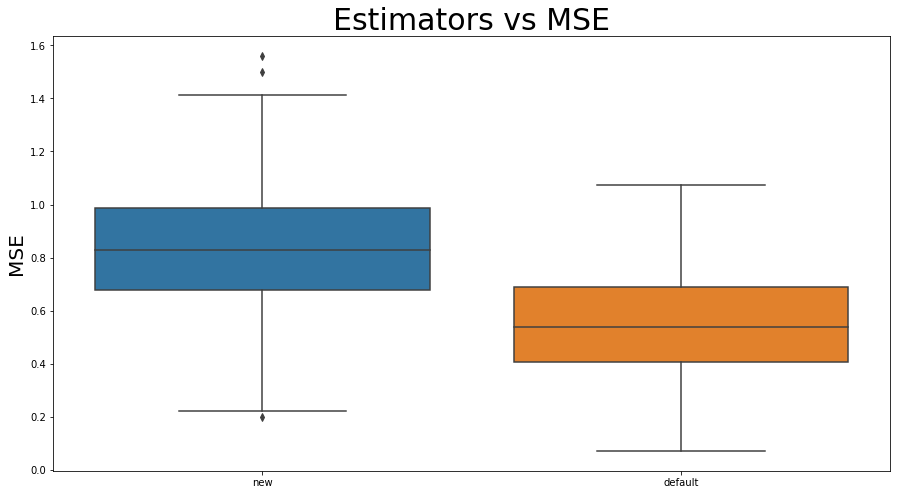

In [100]:
#Compare default XGB vs optimised XGB
XGB_params = XGB_res.best_params

models_XGB = {}

models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)
models_XGB['default'] = xgboost.XGBRegressor()

results_XGB = train_and_test_regressor(models_XGB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_XGB)

In [101]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(XGB_res)

Fitting 10
Fitting 30
Fitting 50
Fitting 70
Fitting 90
Fitting 110
Fitting 130
Fitting 150
Fitting 170
Fitting 190
Fitting 210
Fitting 230
Fitting 250
Fitting 270
Fitting 290
Fitting 310
Fitting 330
Fitting 350
Fitting 370
Fitting 390
Fitting 410
Fitting 430
Fitting 450
Fitting 470
Fitting 490
Calculating bootstrap score for 10
Calculating bootstrap score for 30
Calculating bootstrap score for 50
Calculating bootstrap score for 70
Calculating bootstrap score for 90
Calculating bootstrap score for 110
Calculating bootstrap score for 130
Calculating bootstrap score for 150
Calculating bootstrap score for 170
Calculating bootstrap score for 190
Calculating bootstrap score for 210
Calculating bootstrap score for 230
Calculating bootstrap score for 250
Calculating bootstrap score for 270
Calculating bootstrap score for 290
Calculating bootstrap score for 310
Calculating bootstrap score for 330
Calculating bootstrap score for 350
Calculating bootstrap score for 370
Calculating bootstrap scor

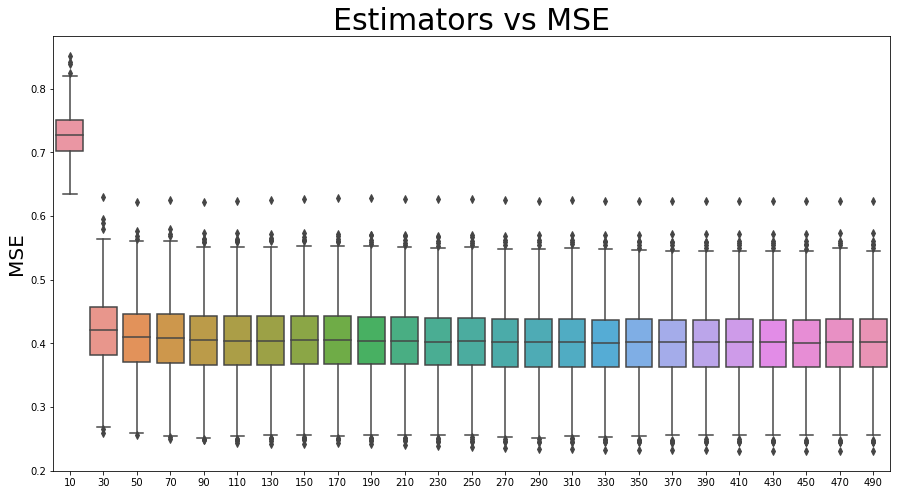

In [116]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = xgboost.XGBRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

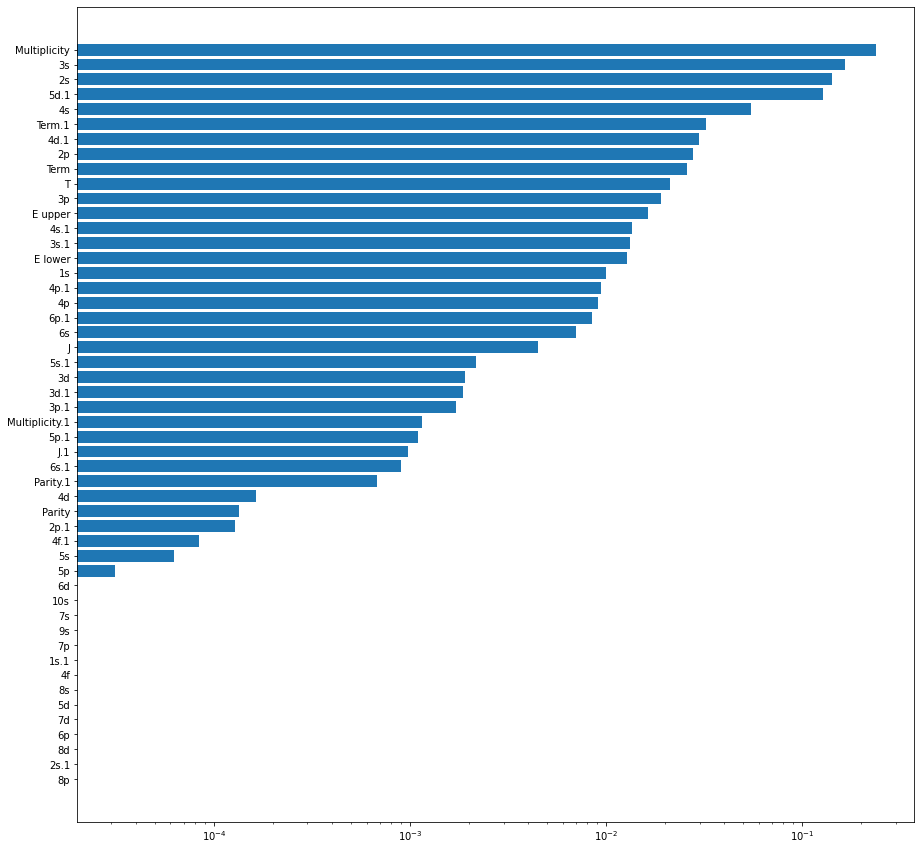

In [112]:
#Visualising feature importances for the optimal XGB model
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

## LightGBM

In [119]:
LightGBM_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'num_leaves' : [2, 512],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = LightGBM

LightGBM_res = main(X = X_train, y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 10)

'''with open(f'LightGBM_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)'''

'''with open(f'LightGBM_Scaled_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)'''

'''with open(f'LightGBM_Extended_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)'''

'''with open(f'LightGBM_SHIFT_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)'''

[I 2023-03-24 14:21:10,748] A new study created in memory with name: no-name-2c8ce8da-40b8-42bb-a5ac-2ddd01882522


Start hyperparameter optimization


/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/10 [00:00<?, ?it/s]

{'n_estimators': 500, 'learning_rate': 0.13084365560980285, 'num_leaves': 232, 'reg_alpha': 0.00942985894349966, 'reg_lambda': 0.07401531507801822}
{'n_estimators': 500, 'learning_rate': 0.06229990040010975, 'num_leaves': 256, 'reg_alpha': 1.164294065263709e-06, 'reg_lambda': 0.0014886826278665173}
[I 2023-03-24 14:21:32,305] Trial 0 finished with value: 0.1652314742937569 and parameters: {'learning_rate': 0.13084365560980285, 'num_leaves': 232, 'reg_alpha': 0.00942985894349966, 'reg_lambda': 0.07401531507801822}. Best is trial 0 with value: 0.1652314742937569.
{'n_estimators': 500, 'learning_rate': 0.12426638485400232, 'num_leaves': 231, 'reg_alpha': 0.00024264204279798125, 'reg_lambda': 8.185377517235579e-06}
[I 2023-03-24 14:21:33,885] Trial 1 finished with value: 0.17647477751702992 and parameters: {'learning_rate': 0.06229990040010975, 'num_leaves': 256, 'reg_alpha': 1.164294065263709e-06, 'reg_lambda': 0.0014886826278665173}. Best is trial 0 with value: 0.1652314742937569.
{'n_es

"with open(f'LightGBM_SHIFT_optimal_parameters', 'w') as fp:\n    json.dump(LightGBM_res.best_params, fp)"

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


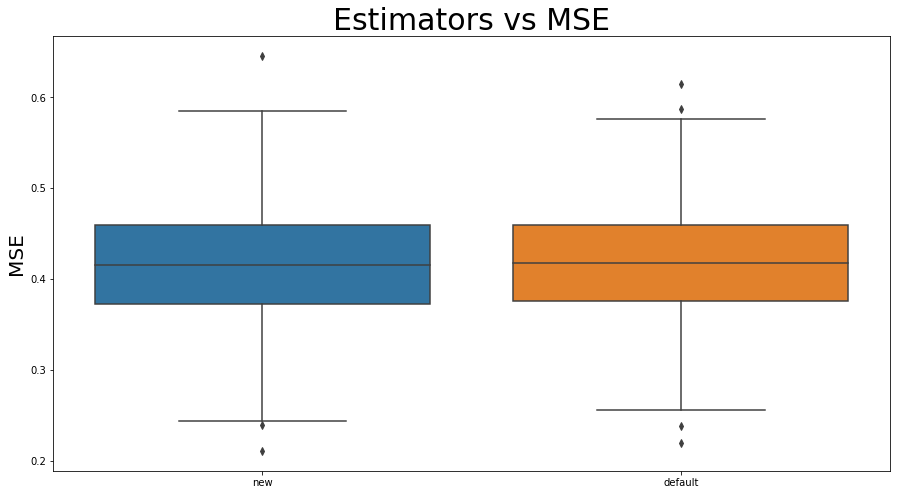

In [122]:
#Compare default LightGBM vs optimised LightGBM
LightGBM_params = LightGBM_res.best_params

models_LightGBM = {}

models_LightGBM['new'] = lightgbm.LGBMRegressor(**LightGBM_params, n_estimators = 500)
models_LightGBM['default'] = lightgbm.LGBMRegressor()

results_LightGBM = train_and_test_regressor(models_LightGBM, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_LightGBM)

In [121]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(LightGBM_res)

Fitting 10
Fitting 30
Fitting 50
Fitting 70
Fitting 90
Fitting 110
Fitting 130
Fitting 150
Fitting 170
Fitting 190
Fitting 210
Fitting 230
Fitting 250
Fitting 270
Fitting 290
Fitting 310
Fitting 330
Fitting 350
Fitting 370
Fitting 390
Fitting 410
Fitting 430
Fitting 450
Fitting 470
Fitting 490
Calculating bootstrap score for 10
Calculating bootstrap score for 30
Calculating bootstrap score for 50
Calculating bootstrap score for 70
Calculating bootstrap score for 90
Calculating bootstrap score for 110
Calculating bootstrap score for 130
Calculating bootstrap score for 150
Calculating bootstrap score for 170
Calculating bootstrap score for 190
Calculating bootstrap score for 210
Calculating bootstrap score for 230
Calculating bootstrap score for 250
Calculating bootstrap score for 270
Calculating bootstrap score for 290
Calculating bootstrap score for 310
Calculating bootstrap score for 330
Calculating bootstrap score for 350
Calculating bootstrap score for 370
Calculating bootstrap scor

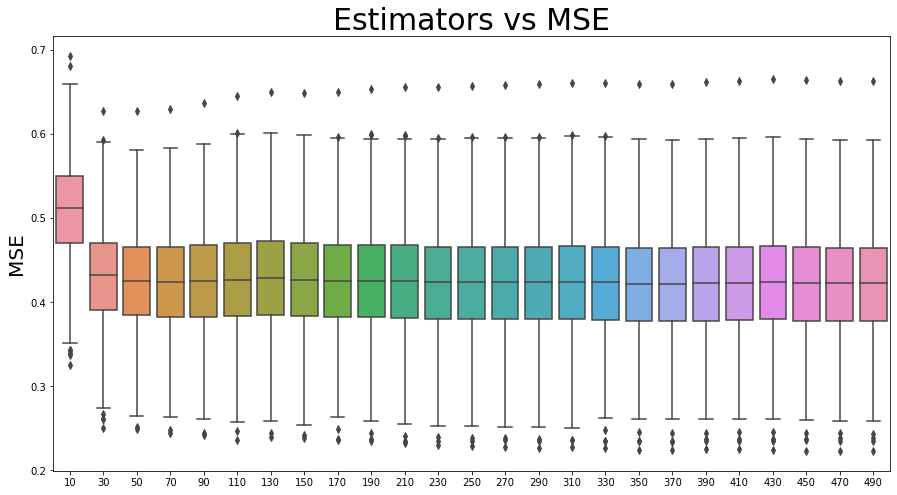

In [123]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = lightgbm.LGBMRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

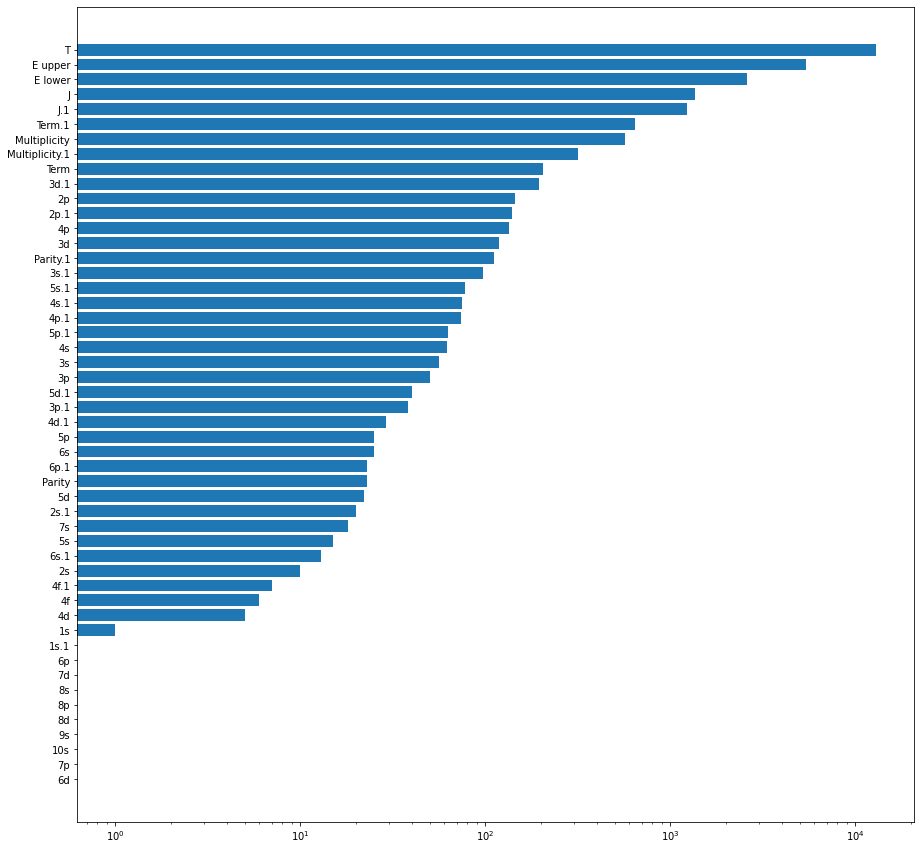

In [124]:
feature_importance = models_LightGBM['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [32]:
print(torch.cuda.is_available())

True


In [16]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : -1
    }

model_name = TabNet

start_time = time.time()
TabNet_res = main(X = X_train, y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 10)
print(f'Optuning took {time.time() - start_time}')

'''with open(f'TabNet_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)
'''
'''with open(f'TabNet_Extended_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)'''

[I 2023-03-24 15:05:45,111] A new study created in memory with name: no-name-2128c259-5b44-4c92-8aaa-bc6735981754


Start hyperparameter optimization


/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

{'device_name': 'cuda', 'n_d': 16, 'n_steps': 4, 'gamma': 1.353704753701939, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.07226990741634365, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 19, 'gamma': 1.1694059476544247, 'n_independent': 19, 'n_shared': 11, 'momentum': 0.01422752456409636, 'mask_type': 'sparsemax'}
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 10, 'gamma': 1.85370658084067, 'n_independent': 14, 'n_shared': 2, 'momentum': 0.0020384892245688103, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 12, 'gamma': 1.4179892635354765, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.08078665804122555, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 9, 'gamma': 1.2535163127818283, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.007697219393238417, 'mask_type': 'sparsemax'}
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 15, 'gamma': 1.7039134825779083, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.003948253237

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 35.03852


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 786.16615


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 50061861.11398


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 33.48053


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 395.05464


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:13:49,193] Trial 8 finished with value: 13.165126544305707 and parameters: {'n_d': 34, 'n_steps': 25, 'gamma': 1.895369898061395, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.13886345774402223, 'mask_type': 'sparsemax'}. Best is trial 7 with value: 11.879171152892159.

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 4912.2052


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 76.54429


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 33.78189


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:16:33,052] Trial 0 finished with value: 6.636315003556495 and parameters: {'n_d': 3, 'n_steps': 18, 'gamma': 1.3003955008567742, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.013225334813940554, 'mask_type': 'entmax'}. Best is trial 0 with value: 6.636315003556495.

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 14.8095


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 9.98743


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 552790064.55882


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 6.52371


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 5.33575


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 102.77466


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 18.25204


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 80.98635


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 10931.19454


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:29:03,535] Trial 3 finished with value: 134.06550597948393 and parameters: {'n_d': 17, 'n_steps': 25, 'gamma': 1.2408798970572499, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.0014947383678763936, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 6.636315003556495.

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 58.1423


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 86.99135


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 408280973.24865


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 14.19986


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 64.39947


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 96.09585


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 2.66933


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 123.78203


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 45.43964


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:36:54,730] Trial 4 finished with value: 7.422662272723746 and parameters: {'n_d': 4, 'n_steps': 18, 'gamma': 1.6192072602610708, 'n_independent': 4, 'n_shared': 10, 'momentum': 0.027788109259825788, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 6.636315003556495.

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 106.04153


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 11.19171


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 65.12741


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:38:54,820] Trial 5 finished with value: 9.217332593864137 and parameters: {'n_d': 47, 'n_steps': 7, 'gamma': 1.5388910781302683, 'n_independent': 19, 'n_shared': 15, 'momentum': 0.18480181630491108, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 6.636315003556495.

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 611.14553


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 9.21741


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 39.59771


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:43:51,173] Trial 6 finished with value: 4.243502343851657 and parameters: {'n_d': 48, 'n_steps': 11, 'gamma': 1.299018030556769, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.009805004297039384, 'mask_type': 'entmax'}. Best is trial 6 with value: 4.243502343851657.

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 9082949.72353


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:44:15,603] Trial 1 finished with value: 30148.2344912118 and parameters: {'n_d': 47, 'n_steps': 12, 'gamma': 1.2792317697094315, 'n_independent': 16, 'n_shared': 14, 'momentum': 0.0011176467346434228, 'mask_type': 'sparsemax'}. Best is trial 6 with value: 4.243502343851657.

Early stopping occurred at epoch 139 with best_epoch = 119 and best_eval_mse = 4.21046


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 44.83551


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 4.47198


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 3.3426


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:48:42,039] Trial 2 finished with value: 4.111229422690577 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.499170072087726, 'n_independent': 20, 'n_shared': 12, 'momentum': 0.02393144277384567, 'mask_type': 'sparsemax'}. Best is trial 2 with value: 4.111229422690577.

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 3320.33392


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 146.44629


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 3.43666


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 63.86845


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 52.60878


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 6.28316


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 66.06231


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 6.33892


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 95.95681


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 50.58948


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 53.22488


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 13.17208


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:56:42,258] Trial 10 finished with value: 2.901314082009394 and parameters: {'n_d': 39, 'n_steps': 16, 'gamma': 1.67396067320642, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.012769100734172275, 'mask_type': 'entmax'}. Best is trial 10 with value: 2.901314082009394.

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 191.80752


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 80.85375


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 1406.95556


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 50.44163


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 15:58:48,959] Trial 5 finished with value: 7.091903292393224 and parameters: {'n_d': 2, 'n_steps': 8, 'gamma': 1.7059704909606872, 'n_independent': 18, 'n_shared': 13, 'momentum': 0.05206222750206127, 'mask_type': 'entmax'}. Best is trial 5 with value: 7.091903292393224.

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 364.28599


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 40.09114


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 1.29665


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 57.39659


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 97.37437


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 4810.17927


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 4.03665


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:04:52,536] Trial 9 finished with value: 1.880597316798943 and parameters: {'n_d': 28, 'n_steps': 5, 'gamma': 1.972840875734107, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.014638019825182449, 'mask_type': 'sparsemax'}. Best is trial 9 with value: 1.880597316798943.

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 170.63721


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 47.65919


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 44.86069


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 2439.26512


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:11:53,939] Trial 9 finished with value: 47.71949513680505 and parameters: {'n_d': 42, 'n_steps': 11, 'gamma': 1.8256690139028948, 'n_independent': 17, 'n_shared': 13, 'momentum': 0.005636917445937057, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 7.091903292393224.

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 40.21197


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 38.91688


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:13:17,745] Trial 3 finished with value: 8.118758703971178 and parameters: {'n_d': 35, 'n_steps': 12, 'gamma': 1.4179892635354765, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.08078665804122555, 'mask_type': 'entmax'}. Best is trial 5 with value: 7.091903292393224.

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 39.85814


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:14:49,650] Trial 8 finished with value: 6.803562861731175 and parameters: {'n_d': 6, 'n_steps': 10, 'gamma': 1.3678040635686435, 'n_independent': 12, 'n_shared': 12, 'momentum': 0.032235946220779285, 'mask_type': 'entmax'}. Best is trial 8 with value: 6.803562861731175.

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 48.86803


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 89.81069


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:16:12,807] Trial 1 finished with value: 11.118660119401405 and parameters: {'n_d': 25, 'n_steps': 19, 'gamma': 1.1694059476544247, 'n_independent': 19, 'n_shared': 11, 'momentum': 0.01422752456409636, 'mask_type': 'sparsemax'}. Best is trial 8 with value: 6.803562861731175.

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 48.56331


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 4.28739


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 5646.58999


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 7.43546


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 2.87142


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 7645.20872


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 5.62426


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 5.00705


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 44.84125


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:22:30,706] Trial 7 finished with value: 8.36851412878348 and parameters: {'n_d': 37, 'n_steps': 16, 'gamma': 1.5821146495488887, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.09970770647775978, 'mask_type': 'sparsemax'}. Best is trial 8 with value: 6.803562861731175.

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1944.99425


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 3.89505


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.84714


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 38.28425


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 2559.64323


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 527.79875


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 64.1691


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 0.72187


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1757.95635


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:27:49,383] Trial 2 finished with value: 59.84073507585938 and parameters: {'n_d': 29, 'n_steps': 10, 'gamma': 1.85370658084067, 'n_independent': 14, 'n_shared': 2, 'momentum': 0.0020384892245688103, 'mask_type': 'entmax'}. Best is trial 8 with value: 6.803562861731175.

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 3.66244


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:28:03,067] Trial 0 finished with value: 1.4897811630157267 and parameters: {'n_d': 16, 'n_steps': 4, 'gamma': 1.353704753701939, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.07226990741634365, 'mask_type': 'entmax'}. Best is trial 0 with value: 1.4897811630157267.

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 184.18933


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:28:04,831] Trial 6 finished with value: 10.3878632949516 and parameters: {'n_d': 43, 'n_steps': 15, 'gamma': 1.7039134825779083, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.003948253237643565, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 1.4897811630157267.

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 374.51405


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2023-03-24 16:28:11,598] Trial 4 finished with value: 9.025227463838497 and parameters: {'n_d': 40, 'n_steps': 9, 'gamma': 1.2535163127818283, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.007697219393238417, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 1.4897811630157267.
Best parameters: {'n_d': 16, 'n_steps': 4, 'gamma': 1.353704753701939, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.07226990741634365, 'mask_type': 'entmax'}
Optuning took 4946.493027210236


"with open(f'TabNet_Extended_optimal_parameters', 'w') as fp:\n    json.dump(TabNet_res.best_params, fp)"

Fitting TabNet_new

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.28204
Fitting TabNet_default


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.21485
Calculating bootstrap score for TabNet_new


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Calculating bootstrap score for TabNet_default


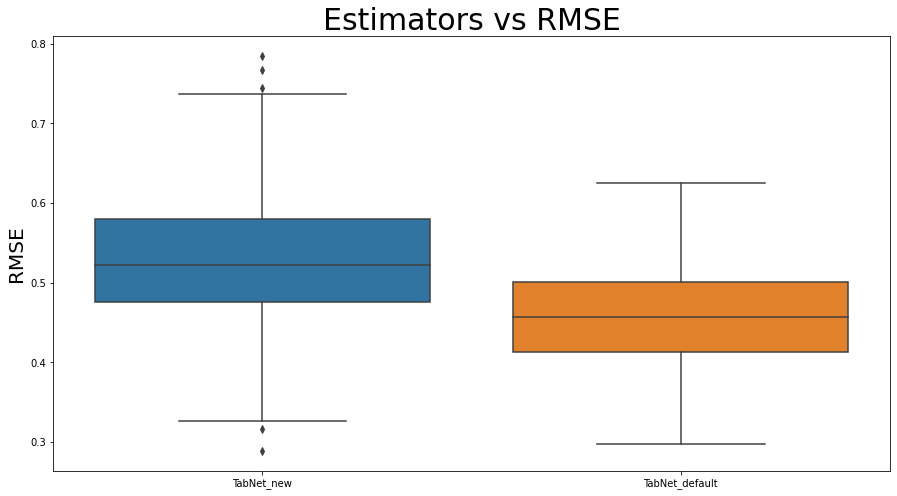

In [31]:
TabNet_params = TabNet_res.best_params
TabNet_params['device_name'] = 'cuda'

models_TabNet = {}

models_TabNet['TabNet_new'] = TabNet(TabNet_params)
models_TabNet['TabNet_default'] = TabNet({'device_name' : 'cuda',
                                   'n_d' : 8})

results_TabNet = train_and_test_regressor(models_TabNet, X_train, Y_train, X_test, Y_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [33]:
optuna.visualization.plot_param_importances(TabNet_res)

In [34]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

Getting KNN predictions
Getting RF predictions
Getting GB predictions
Getting XGB predictions
[13:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet predictions

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Plotting KNN predictions
Plotting RF predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB predictions
Plotting XGB predictions
Plotting TabNet predictions


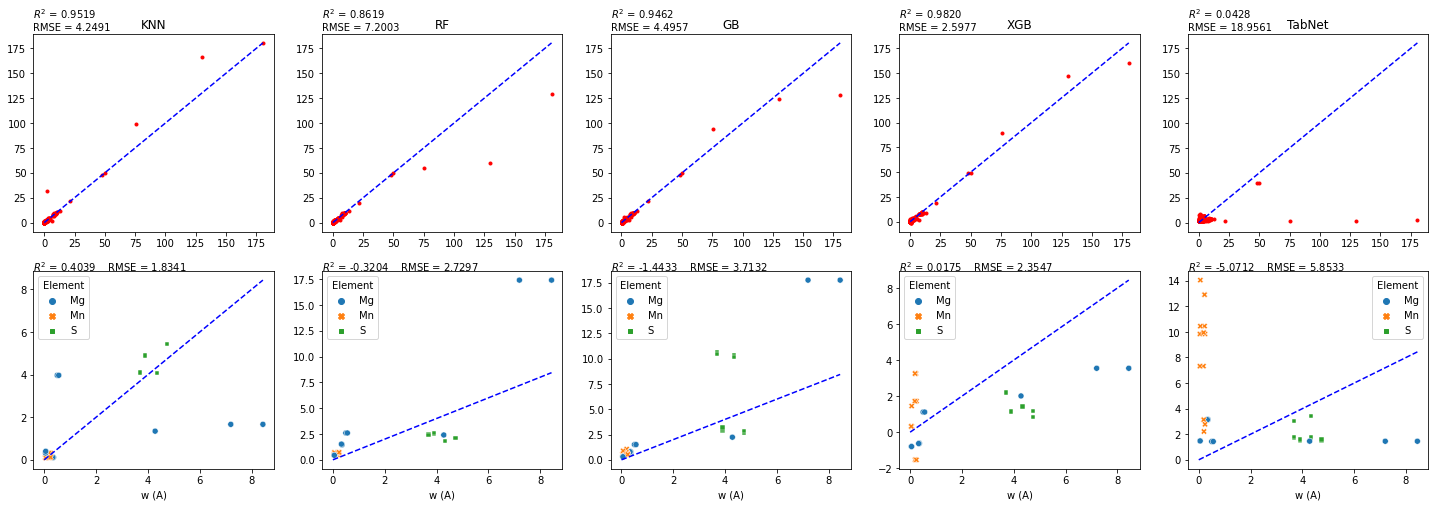

({'KNN': array([3.67868103e-02, 4.08068019e-02, 3.99337040e-02, 1.13916788e-01,
         6.80000000e-02, 7.83396520e-02, 1.51461483e+00, 1.37000000e-01,
         1.14496067e-01, 3.50000000e-02, 1.68074812e-01, 1.38350992e-01,
         7.81127322e-02, 2.69494766e-02, 6.46322026e-02, 3.67868112e-02,
         8.02871354e-01, 2.92527069e-02, 1.77744998e-02, 9.38872678e-02,
         7.83397679e-02, 7.80141870e-02, 7.80000000e-02, 2.63998371e-02,
         7.81127322e-02, 1.85304508e-01, 8.34955379e-03, 3.02411470e-02,
         8.64182604e-02, 1.65000000e+00, 7.80000000e-02, 1.36405436e-01,
         1.17162695e-01, 1.51803582e-01, 4.87878119e-03, 1.37000000e-01,
         8.31067011e-02, 3.80000000e-02, 3.72126113e-01, 6.32703303e-01,
         3.19809646e-01, 4.10000000e-01, 4.85695367e-01, 1.72332456e+00,
         2.50896854e-01, 1.28945062e+00, 7.01195472e-01, 1.57000000e+00,
         6.92207095e-01, 1.73724199e+00, 4.60000000e-01, 2.12000000e+00,
         3.79990290e-01, 3.66223979e-01, 4.0

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

## In case on scaled *targets*

Getting KNN_Extended predictions
Getting RF_Extended predictions
Getting GB_Extended predictions
Getting XGB_Extended predictions
Getting LightGBM_Extended predictions
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



Plotting KNN_Extended predictions
Plotting RF_Extended predictions
Plotting GB_Extended predictions
Plotting XGB_Extended predictions
Plotting LightGBM_Extended predictions
Plotting TabNet_Extended predictions


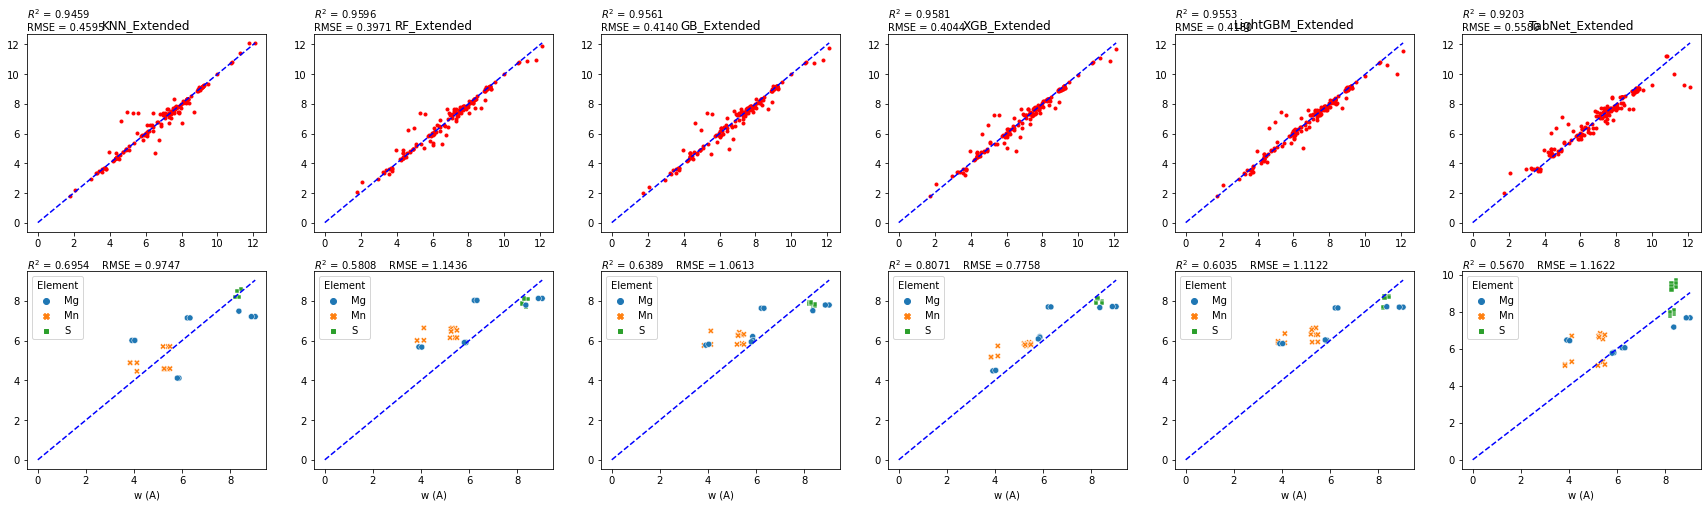

In [40]:
if augmented_train_set == True and scaled_target == True:
    name_add = '_Extended'
elif scaled_target == True:
    name_add = '_Scaled'
models = ['KNN' + name_add, 'RF' + name_add, 'GB' + name_add, 'XGB' + name_add, 'LightGBM' + name_add, 'TabNet' + name_add]

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d, X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem)

In [44]:
Y_train = (np.exp(Y_train) - 1) * epsilon
Y_test = (np.exp(Y_test) - 1) * epsilon
Y_elem = (np.exp(Y_elem) - 1) * epsilon
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

<ipython-input-44-b13a9f6dc261>:5: RuntimeWarning:

overflow encountered in exp



In [45]:
predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(Y_test, y_pred)
    RMSE[name] = mean_squared_error(Y_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(Y_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(Y_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (5*len(models_d), 4*2))
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(Y_test, preds[name], 'r.')
    ax[0, i].plot([0, np.amax(Y_test)], [0, np.amax(Y_test)], color = 'b', ls = '--')
    ax[0, i].set_title(f'{name}')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}  \n  RMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = Y_elem, y = preds_elem[name], ax = ax[1, i], style = L_elem['Element'], hue = L_elem['Element'])
    ax[1, i].plot([0, np.amax(Y_elem)], [0, np.amax(Y_elem)], color = 'b', ls = '--')
    ax[1, i].text(x = 0, y = 1, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
    i += 1
plt.show()

ValueError: ignored

## Shift

In [ ]:
print(XS_train.shape, XS_test.shape, XS_elem.shape)
print(XW_train.shape, XW_test.shape, XW_elem.shape)
#print(XS_elem)

(275, 50) (58, 50) (20, 50)
(743, 50) (154, 50) (34, 50)


In [ ]:
print(YS_elem)

2      0.350000
3      0.353000
4      0.330000
587    4.342105
588    3.687708
589    4.342105
590    3.687708
591    4.342105
592    3.687708
593    4.736842
594    3.903226
595    4.736842
596    3.903226
597    4.736842
598    3.903226
730    4.280000
731    8.440000
732    7.200000
733    0.500000
734    0.560000
Name: w (A), dtype: float64


Getting KNN_SHIFT predictions
Getting GB_SHIFT predictions
Getting XGB_SHIFT predictions
[10:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_SHIFT predictions

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 21.197
Best weights from best epoch are automatically used!
Plotting KNN_SHIFT predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB_SHIFT predictions
Plotting XGB_SHIFT predictions
Plotting TabNet_SHIFT predictions


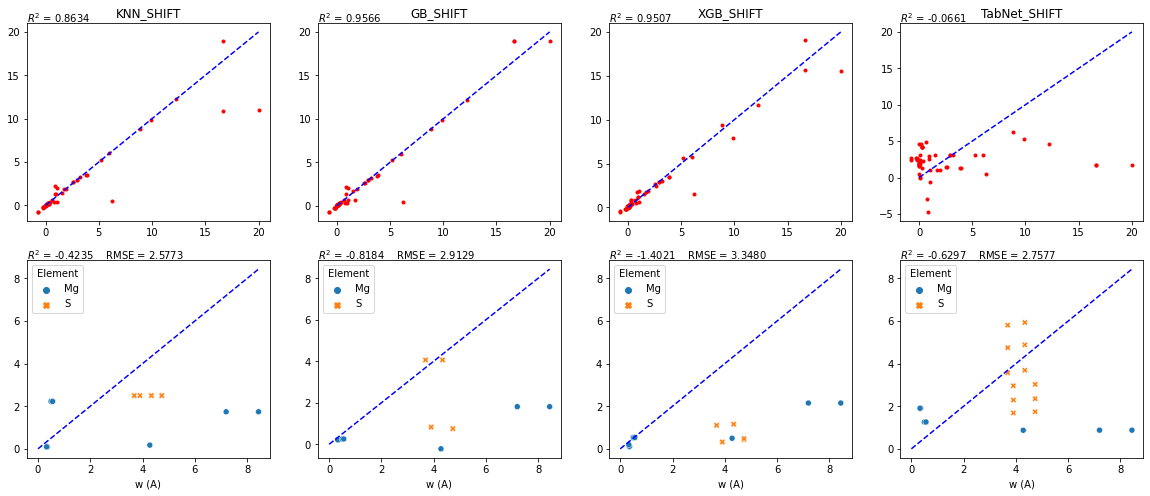

({'GB_SHIFT': array([-2.59310346e-01,  3.91666204e-02, -2.35672990e-01, -6.65330643e-01,
         -1.97868738e-01,  4.12027283e-02, -2.35810597e-01,  4.26402963e-02,
         -1.06844387e-02,  8.81676419e-02, -1.97868738e-01, -2.03051373e-02,
         -6.65468250e-01,  4.33106305e-02,  4.26402963e-02,  1.07328810e-01,
          1.59113465e-01,  1.59903665e-01,  4.36632002e-02,  3.01826828e-01,
          6.55451760e-02,  1.05224689e-01,  1.05224689e-01,  9.98871562e-02,
          4.01470207e-02,  1.94114458e-01,  1.46755968e-01,  2.47311336e-01,
          3.01826828e-01,  6.23425829e-01,  6.45440574e-01,  3.34044165e-01,
          1.92704852e+00,  2.02773660e+00,  2.88451743e-01,  1.32040544e+00,
          3.70799218e-01,  2.15029230e+00,  6.55432110e-01,  2.67965532e+00,
          4.32047723e-01,  2.67965532e+00,  1.70248872e+00,  3.01826828e-01,
          1.89490980e+01,  3.54710071e+00,  5.21354720e+00,  5.98792639e+00,
          1.89490980e+01,  3.21656767e+00,  4.51844911e-01,  2.9

In [ ]:
models = ['KNN_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XS_train, YS_train, XS_test, YS_test, XS_elem, YS_elem, LS_elem)

## Comparing old (handmade/handtuned) and auto new TabNet

In [ ]:
models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results)


models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

pr, elem, fig, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

KeyError: ignored

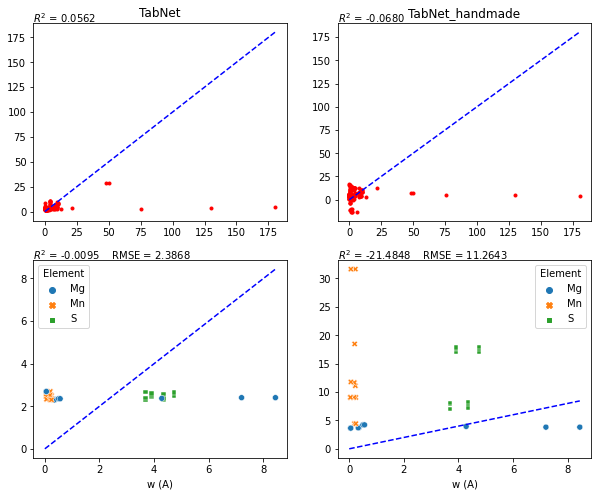

In [ ]:
#ax[0, 0].set_xlim(0, 15)
#ax[0, 0].set_ylim(0, 15)
#ax[0, 1].set_xlim(0, 15)
#ax[0, 1].set_ylim(0, 15)
fig

# Temperature dependence

In [ ]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

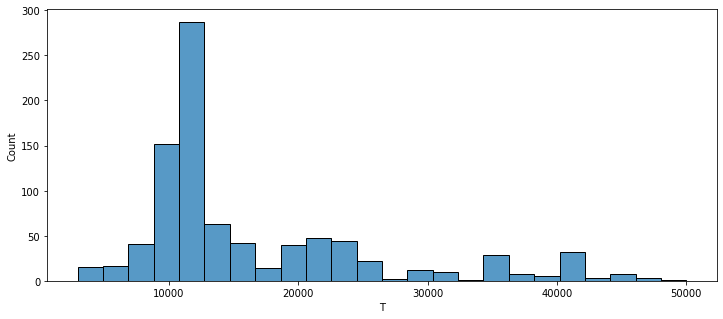

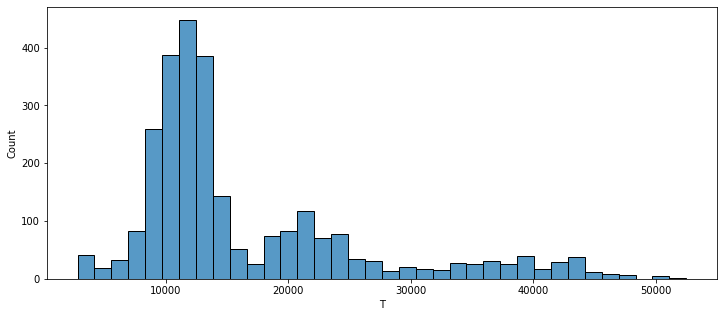

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width, x = 'T')
plt.show()

fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_extended, x = 'T')
plt.show()

In [ ]:
data_width_extended['Wavelength'].value_counts()

538.337000    114
667.815000     78
501.568000     69
471.313916     54
471.315614     54
             ... 
130.603000      3
132.656000      3
141.195000      3
141.193000      3
373.994000      3
Name: Wavelength, Length: 427, dtype: int64

In [ ]:
data_width_extended = data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


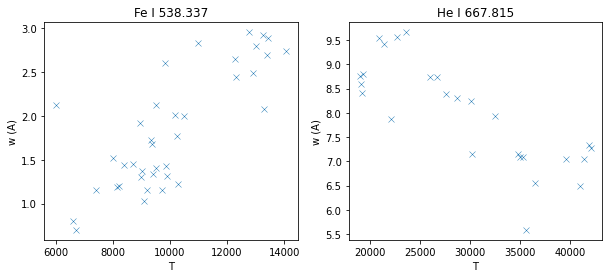

	Points plotted are only original data (without artificial points)


In [ ]:
Fe_wavelength = 538.3370
He_wavelength = 667.8150

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], ax = ax[0], marker = 'x')
sns.scatterplot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], ax = ax[1], marker = 'x')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [ ]:
#Define temperature range in each case

Fe_low, Fe_high = data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['max']
He_low, He_high = data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['max']

npoints = 1000
#Fe_temperatures = np.linspace(Fe_low, Fe_high, npoints)
#He_temperatures = np.linspace(He_low, He_high, npoints)

Fe_temperatures = np.linspace(5000, 15000, npoints)
He_temperatures = np.linspace(15000, 45000, npoints)

Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]

for i in range(npoints):
    Fe_unit['T'] = Fe_temperatures[i]
    if i == 0:
        temperature_test_data = Fe_unit
    else:
        temperature_test_data = pd.concat([temperature_test_data, Fe_unit])

for i in range(npoints):
    He_unit['T'] = He_temperatures[i]
    temperature_test_data = pd.concat([temperature_test_data, He_unit])

temperature_test_data = temperature_test_data.drop(columns=['Element', 'Wavelength', 'Z number'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
YW_test.describe()

count    154.000000
mean       5.647310
std       19.438067
min        0.004844
25%        0.217534
50%        1.493243
75%        4.016393
max      180.500000
Name: w (A), dtype: float64

In [ ]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Scaled']
models_d = create_models_dict(models)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        print(type(target_width_extended))
        model.fit(data_width_extended, np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended, np.log(1 + target_width_extended / epsilon))

temperature_test_predictions = {}
for name, model in models_d.items():
    temperature_test_predictions[name] = model.predict(temperature_test_data)

Training KNN_Extended model
Training XGB_Extended model
[13:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training TabNet_Scaled model
<class 'pandas.core.series.Series'>

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.05608
Best weights from best epoch are automatically used!


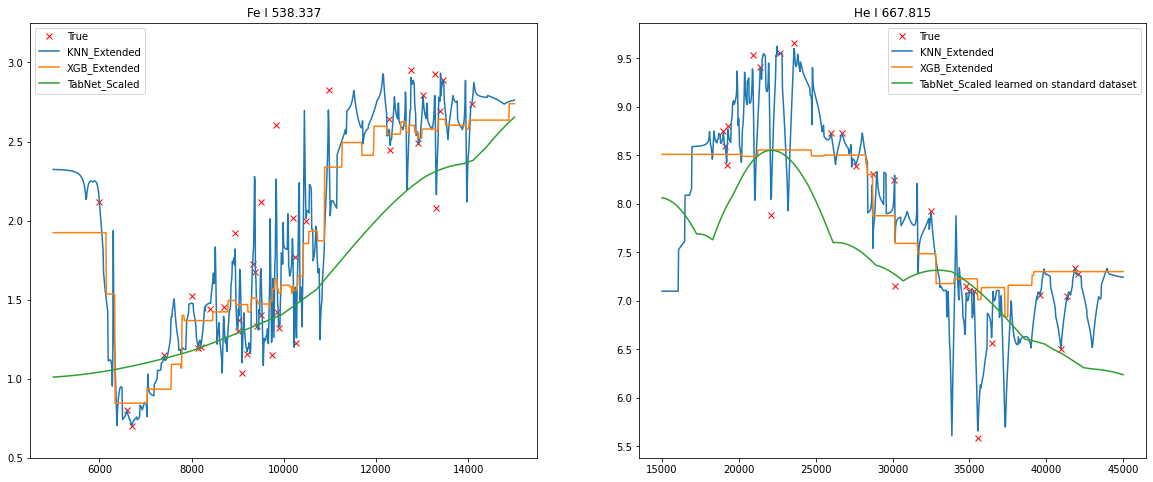

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
ax[1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions[models[0]][:1000]) - 1) * epsilon, label = f'{models[0]}')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions[models[0]][1000:]) - 1) * epsilon, label = f'{models[0]}')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions[models[1]][:1000]) - 1) * epsilon, label = f'{models[1]}')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions[models[1]][1000:]) - 1) * epsilon, label = f'{models[1]}')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions[models[2]][:1000]) - 1) * epsilon, label = f'{models[2]}')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions[models[2]][1000:]) - 1) * epsilon, label = f'{models[2]} learned on standard dataset')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

ax[0].legend()
ax[1].legend()

ax[0].set_ylim(0.5, 3.25)

plt.show()

# Pedicting Stark parameters

In [ ]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

In [ ]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Extended']
models_d = create_models_dict(models)
epsilon = 1e-3

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon))

Training KNN_Extended model
Training XGB_Extended model
[10:57:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training TabNet_Extended model

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 0.17635
Best weights from best epoch are automatically used!


In [ ]:
data_predictions = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='A:BC'
                   )
data_predictions['Term'] = term_to_number(data_predictions['Term'])
data_predictions['Term.1'] = term_to_number(data_predictions['Term.1'])

In [ ]:
predictions = {}
for name, model in models_d.items():
    predictions[name] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))

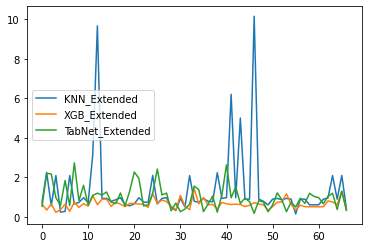

In [ ]:
fig, ax = plt.subplots()
for name, model in predictions.items():
    ax.plot((np.exp(model) - 1) * epsilon, label = f'{name}')

plt.legend()
plt.show()

In [ ]:
predictions['XGB_Extended']

np.savetxt('Fe predictions.csv', (np.exp(predictions['XGB_Extended']) - 1) * epsilon, delimiter = ',')

In [ ]:
data_width_extended.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,...,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2.691000e+03,2691.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16475.397562
std,216.138500,15.972465,0.421403,0.736961,2.178343,0.905386,2.719631,3.993686,0.686838,1.678609,...,0.033377,0.047175,0.033377,0.033377,1.247288,1.311591,0.489341,1.431801,3.324122e+06,9473.849984
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2809.523810
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10500.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20265.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,52500.000000


# Auxilary functions

In [ ]:
d = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='BD:BE'
                   )

In [ ]:
with open("insert.txt", "w") as output:
    output.write('insert into starknew (line_id, temp, e_dens, fwhm, alpha, beta, width_ref, shift_ref) \nvalues')
    for index, item in d.iterrows():
        if not np.isnan(item['fwhm']):
            line = f"({item['line_id']}, 7200, 1.0E17, {item['fwhm']}, 0, 0, 19, 19),\n"
            output.write(line)

In [ ]:
with open("delete.txt", "w") as output:
    output.write('delete from starknew where line_id in (')
    for index, item in d.iterrows():
        line = f"{int(item['line_id'])}, "
        output.write(line)
    output.write(')')

# Debugging

In [ ]:
!nvidia-smi

Fri Oct  7 16:36:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |    916MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import datetime
print(datetime.datetime.now())
predictions = {}
for i in range(100):
    models = [f'TabNet_Extended']
    models_d = create_models_dict(models)
    epsilon = 1e-3

    for name, model in models_d.items():
        print(f"Training {name}_{i} model")
        if 'TabNet' in name:
            model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
        predictions[f'{name}_{i}'] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))
print(datetime.datetime.now())

2022-10-07 16:36:48.896124
Training TabNet_Extended_0 model

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.04255
Training TabNet_Extended_1 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 6.12583
Training TabNet_Extended_2 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 5.84129
Training TabNet_Extended_3 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 5.75448
Training TabNet_Extended_4 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.35698
Training TabNet_Extended_5 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.52399
Training TabNet_Extended_6 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 6.13257
Training TabNet_Extended_7 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 7.19106
Training TabNet_Extended_8 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.58952
Training TabNet_Extended_9 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 8.97335
Training TabNet_Extended_10 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 5.74376
Training TabNet_Extended_11 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.5148
Training TabNet_Extended_12 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.45584
Training TabNet_Extended_13 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 4.08152
Training TabNet_Extended_14 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 5.10881
Training TabNet_Extended_15 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 5.77577
Training TabNet_Extended_16 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 6.30728
Training TabNet_Extended_17 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 8.08837
Training TabNet_Extended_18 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.25321
Training TabNet_Extended_19 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 5.85513
Training TabNet_Extended_20 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 5.95309
Training TabNet_Extended_21 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.52942
Training TabNet_Extended_22 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 6.17833
Training TabNet_Extended_23 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.19966
Training TabNet_Extended_24 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 7.48535
Training TabNet_Extended_25 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 4.3064
Training TabNet_Extended_26 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.91902
Training TabNet_Extended_27 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 6.61379
Training TabNet_Extended_28 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.43085
Training TabNet_Extended_29 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 4.20461
Training TabNet_Extended_30 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 4.57072
Training TabNet_Extended_31 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 6.61023
Training TabNet_Extended_32 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 6.32855
Training TabNet_Extended_33 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 4.89149
Training TabNet_Extended_34 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.05503
Training TabNet_Extended_35 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.2417
Training TabNet_Extended_36 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 5.03381
Training TabNet_Extended_37 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 5.31025
Training TabNet_Extended_38 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 4.81982
Training TabNet_Extended_39 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 4.59477
Training TabNet_Extended_40 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.93886
Training TabNet_Extended_41 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.6699
Training TabNet_Extended_42 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 6.14118
Training TabNet_Extended_43 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 5.2026
Training TabNet_Extended_44 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.44702
Training TabNet_Extended_45 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4.17587
Training TabNet_Extended_46 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.04255
Training TabNet_Extended_47 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 3.01732
Training TabNet_Extended_48 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 4.59477
Training TabNet_Extended_49 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 4.65963
Training TabNet_Extended_50 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 4.43146
Training TabNet_Extended_51 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 6.49016
Training TabNet_Extended_52 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.97446
Training TabNet_Extended_53 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.98373
Training TabNet_Extended_54 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 3.67056
Training TabNet_Extended_55 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.82365
Training TabNet_Extended_56 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.14496
Training TabNet_Extended_57 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 5.79771
Training TabNet_Extended_58 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.34682
Training TabNet_Extended_59 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 6.45926
Training TabNet_Extended_60 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 3.37794
Training TabNet_Extended_61 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 6.2687
Training TabNet_Extended_62 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 6.15393
Training TabNet_Extended_63 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.101
Training TabNet_Extended_64 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 1.7955
Training TabNet_Extended_65 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 4.57262
Training TabNet_Extended_66 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 4.43933
Training TabNet_Extended_67 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.93886
Training TabNet_Extended_68 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.75868
Training TabNet_Extended_69 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 5.00476
Training TabNet_Extended_70 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4.37823
Training TabNet_Extended_71 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 4.70403
Training TabNet_Extended_72 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 4.29617
Training TabNet_Extended_73 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.9218
Training TabNet_Extended_74 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.14496
Training TabNet_Extended_75 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.04255
Training TabNet_Extended_76 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 3.04172
Training TabNet_Extended_77 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.44043
Training TabNet_Extended_78 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.18843
Training TabNet_Extended_79 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.65368
Training TabNet_Extended_80 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.86164
Training TabNet_Extended_81 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 4.83234
Training TabNet_Extended_82 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 2.68887
Training TabNet_Extended_83 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 3.64052
Training TabNet_Extended_84 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 8.56167
Training TabNet_Extended_85 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.46708
Training TabNet_Extended_86 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 5.1177
Training TabNet_Extended_87 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 6.37954
Training TabNet_Extended_88 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 3.8318
Training TabNet_Extended_89 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.47013
Training TabNet_Extended_90 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 6.32855
Training TabNet_Extended_91 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 4.91101
Training TabNet_Extended_92 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 6.65984
Training TabNet_Extended_93 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.58952
Training TabNet_Extended_94 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 10.76688
Training TabNet_Extended_95 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 9.29159
Training TabNet_Extended_96 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 5.08264
Training TabNet_Extended_97 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 7.18283
Training TabNet_Extended_98 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.82056
Training TabNet_Extended_99 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.81753
2022-10-07 16:44:36.530796


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
import pickle
with open('100 Predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
from IGTD.Scripts.IGTD_Functions import *

In [ ]:
norm_data = min_max_transform(XW_train.to_numpy())

ranking, corr = generate_feature_distance_ranking(norm_data)

pix = generate_matrix_distance_ranking(5, 10)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


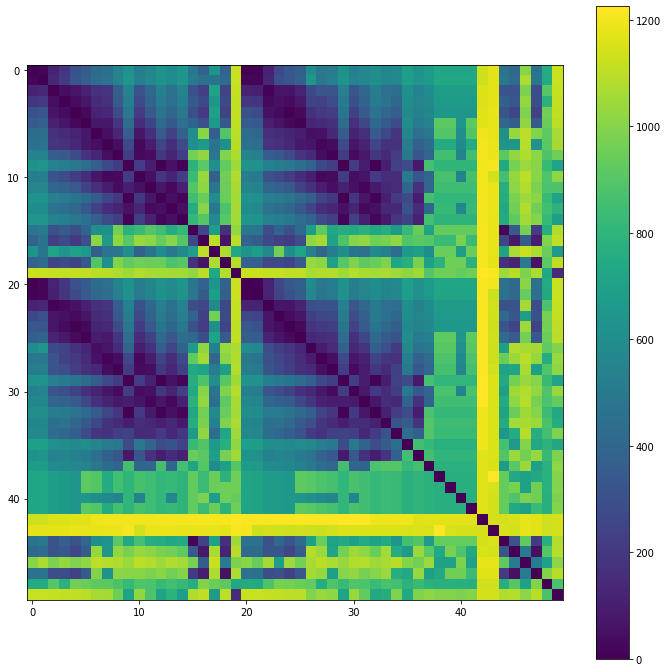

In [ ]:
%matplotlib inline
plt.figure(figsize= (12,12))
plt.imshow(ranking)
plt.colorbar()
plt.show()

In [ ]:
index_record, err_record, run_time = IGTD_square_error(ranking, pix[1], file_name = 'Resss', save_folder = 'content')

Step 0 err: 257691010.5
Step 1 err: 255832285.5
Step 2 err: 246399922.5
Step 3 err: 239328368.5
Step 4 err: 235608396.0
Step 5 err: 232484304.0
Step 6 err: 232088886.0
Step 7 err: 229477898.0
Step 8 err: 227306473.5
Step 9 err: 224024455.5
Step 10 err: 222188044.5
Step 11 err: 221507323.5
Step 12 err: 217669354.5
Step 13 err: 216178668.5
Step 14 err: 210966114.5
Step 15 err: 203040724.5
Step 16 err: 202499243.5
Step 17 err: 201651613.0
Step 18 err: 199403221.5
Step 19 err: 193175922.0
Step 20 err: 189309448.0
Step 21 err: 188777974.0
Step 22 err: 183403447.5
Step 23 err: 179634477.5
Step 24 err: 175187853.5
Step 25 err: 174028828.5
Step 26 err: 166774797.5
Step 27 err: 162546831.0
Step 28 err: 161998117.5
Step 29 err: 161801355.5
Step 30 err: 159855898.0
Step 31 err: 159066295.0
Step 32 err: 154391907.0
Step 33 err: 147493713.5
Step 34 err: 145762498.5
Step 35 err: 141129923.5
Step 36 err: 140800367.5
Step 37 err: 140212771.0
Step 38 err: 139902695.0
Step 39 err: 136925639.0
Step 40 er

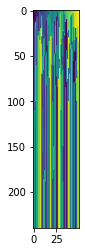

In [ ]:
table_to_image(norm_data, [5, 10], 'Pearson', 'Euclidean', save_image_size = )

In [ ]:
models = ['TabNet_Scaled']
models_d = create_models_dict(models)

for name, models in models_d.items():
    print(f'Fitting model {name}')
    model.fit(XW_train, YW_train)

type(models_d['TabNet_Scaled'])

Fitting model TabNet_Scaled


ValueError: ignored

In [ ]:
%debug

> /usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py(765)check_array()
    763                     "Reshape your data either using array.reshape(-1, 1) if "
    764                     "your data has a single feature or array.reshape(1, -1) "
--> 765                     "if it contains a single sample.".format(array)
    766                 )
    767             # If input is 1D raise error

ipdb> q


In [ ]:
LW_elem

,Element,Wavelength
2,Mg,518.36043
3,Mg,517.26844
4,Mg,516.73213
5,Mn,403.07530
6,Mn,403.30620
7,Mn,403.44830
8,Mn,279.48170
9,Mn,279.82690
10,Mn,280.10810
11,Mn,404.13550


Fitting KNN
Fitting RF
Fitting GB
Fitting XGB
[11:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting TabNet

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 386.1548
Best weights from best epoch are automatically used!
Fitting LightGBM
Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for TabNet
Calculating bootstrap score for LightGBM


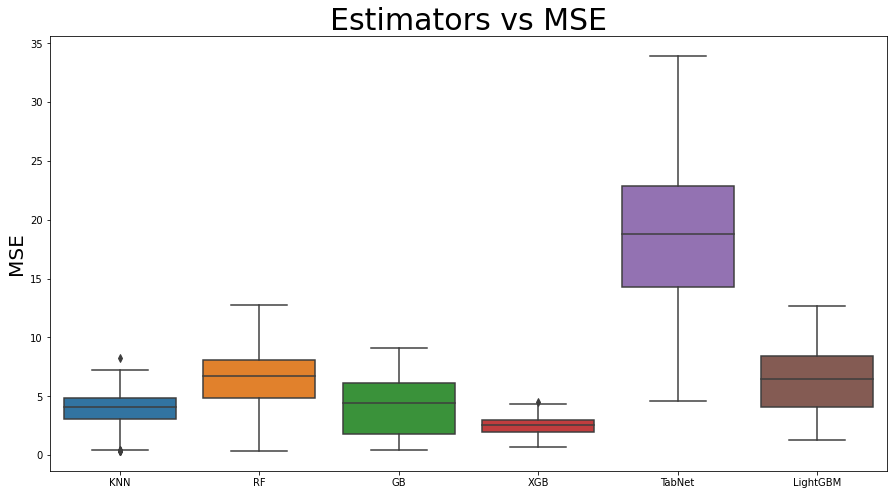

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet', 'LightGBM']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

In [ ]:
%debug

> /content/Stark_ML/models/base_models.py(146)__init__()
    144         super().__init__(params)
    145 
--> 146         self.model = GradientBoostingRegressor(**params)
    147 
    148         self.params = params

ipdb> params
{'learning_rate': 0.46045263398094544, 'num_leaves': 227, 'reg_alpha': 3.275388510467362e-08, 'reg_lambda': 0.20393450817425327}
ipdb> model
*** NameError: name 'model' is not defined
ipdb> q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



[16:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 7.652456533356582
GB model 11.978170490764201
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 85.67093351905685
GB model 67.74644926737481
[16:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.871245347868278
GB model 48.14135844210374
[16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 2.3040662820980895
GB model 2.5558378882546395
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.6383731338990246
GB model 2.1933960069613687

 XGB score 19.827414963255766
GB score 26.52304241909175
{'GB': Gradi

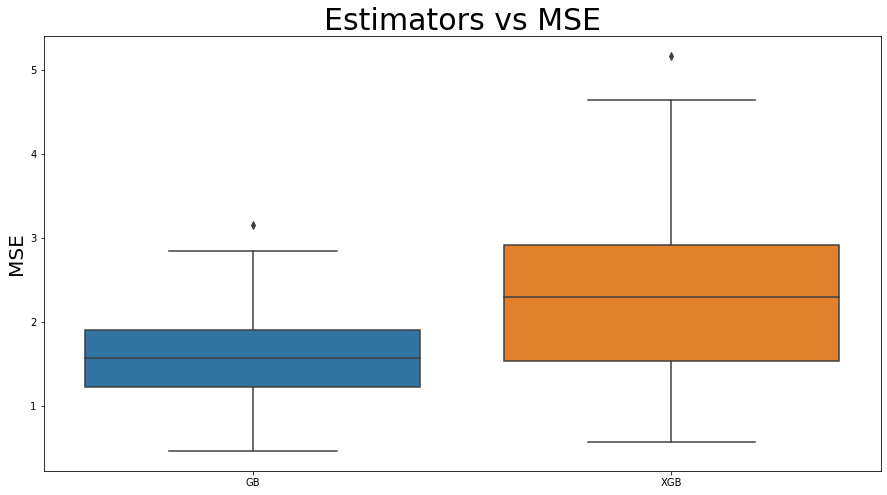

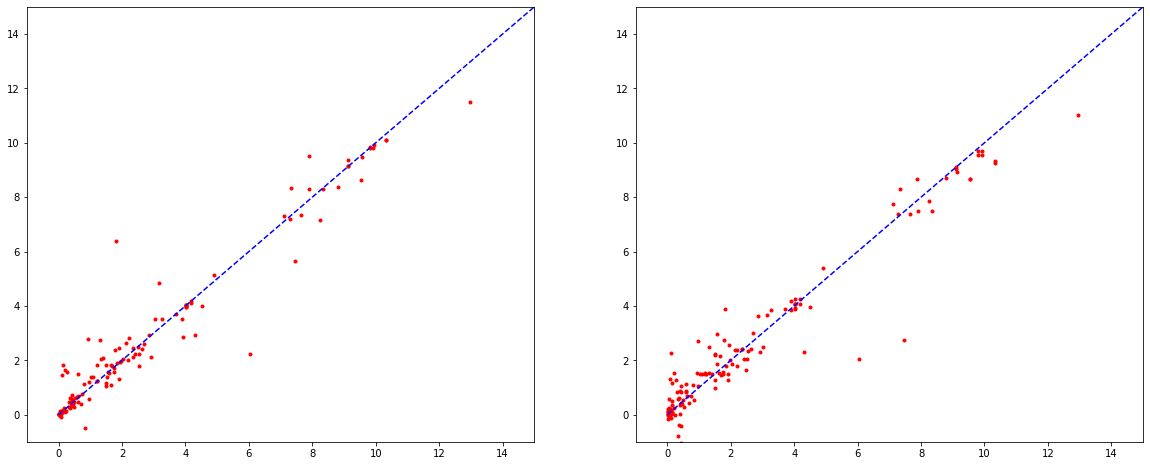

GB MSE: 2.699773000606855
XGB MSE: 5.888925800005179


In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


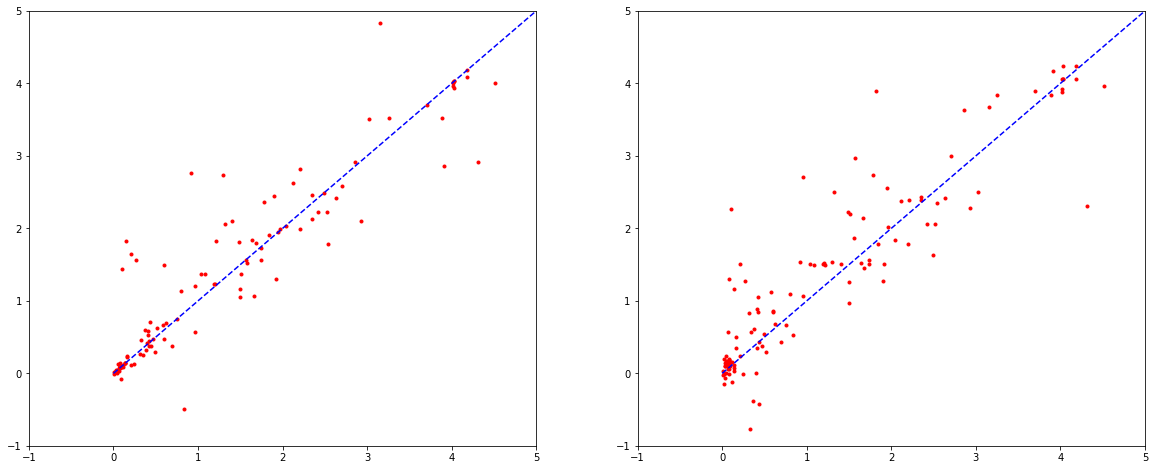

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

TypeError: ignored

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape

(3,)